# GAN to generate Dmel Ecad::GFP patches

In [137]:
# imports

import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [138]:
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=.30)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
# tensorflow_backend.set_session(sess)

In [139]:
# loading pcikled dataset

import pickle

timeRange=range(0,200,10)
xRange = range(500,800,100)
yRange = range(1000,1300,100)

fname = "./datasets/dataset_xr_"+str(xRange)+"_yr_"+str(yRange)+"_tr_"+str(timeRange)
f = open(fname,'rb')
rawListArray, gtListArray = pickle.load(f)

f.close()

In [140]:
# a helper class for batch generation

class Droso():
    def __init__(self, data=None):
        self.data=data
        self.i=0        
        
    def next_batch(self, bs=1):        
        batch = np.zeros((bs,self.data[0].shape[0], self.data[0].shape[1]))
        left = self.i
        right = (self.i + bs)%self.data.shape[0]
        
        if (left<right):
            batch = np.array(self.data[left:right,:,:])
        else:
            batch = np.concatenate((np.array(self.data[left:self.data.shape[0]-1,:,:]), np.array(self.data[0:right+1])))
        self.i = right
        return batch
    
    def getData(self):
        return self.data

In [141]:
rawListArray.shape

(900, 100, 100)

In [142]:
np.random.shuffle(rawListArray)
np.random.shuffle(gtListArray)

In [143]:
# dataset augmentation: flips and rotations
from augment import generate_augmented_set
rawListHalf = rawListArray[0:450,:,:]
gtListHalf = gtListArray[450:,:,:]

rawListArrayAugm = generate_augmented_set(rawListHalf)
np.random.shuffle(rawListArrayAugm)

gtListArrayAugm = generate_augmented_set(gtListHalf)
np.random.shuffle(gtListArrayAugm)

Augmented set generation...
Initial set size: 450x100x100
Final set size: 3600x100x100
Augmented set generation...
Initial set size: 450x100x100
Final set size: 3600x100x100


In [144]:
# sanity checks
x = Droso(rawListArrayAugm)
y = Droso(gtListArrayAugm)

b = x.next_batch(bs=101)
b.shape

a = y.next_batch(bs=101)


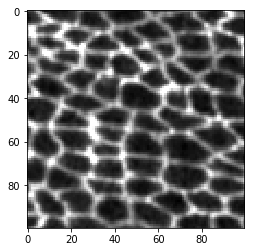

In [145]:
plt.imshow(b[14], cmap="gray")

In [146]:
def discriminator(images, reuse_variables=None):
    with tf.variable_scope(tf.get_variable_scope(), reuse=reuse_variables) as scope:
        # First convolutional and pool layers
        # This finds 32 different 5 x 5 pixel features
        d1features=64
        d_w1 = tf.get_variable('d_w1', [5, 5, 1, d1features], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b1 = tf.get_variable('d_b1', [d1features], initializer=tf.constant_initializer(0))
        d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
        d1 = d1 + d_b1
        d1 = tf.nn.elu(d1)
#         d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        d1 = tf.nn.max_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # Second convolutional and pool layers
        # This finds 64 different 5 x 5 pixel features
        d2features=128
        d_w2 = tf.get_variable('d_w2', [5, 5, d1features, d2features], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b2 = tf.get_variable('d_b2', [d2features], initializer=tf.constant_initializer(0))
        d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
        d2 = d2 + d_b2
        d2 = tf.nn.elu(d2)
#         d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        d2 = tf.nn.max_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
                # Second convolutional and pool layers
        # This finds 64 different 5 x 5 pixel features
        d3features=256
        d_w3 = tf.get_variable('d_w3', [5, 5, d2features, d3features], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b3 = tf.get_variable('d_b3', [d3features], initializer=tf.constant_initializer(0))
        d3 = tf.nn.conv2d(input=d2, filter=d_w3, strides=[1, 1, 1, 1], padding='SAME')
        d3 = d3 + d_b3
        d3 = tf.nn.elu(d3)
#         d3 = tf.nn.avg_pool(d3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        d3 = tf.nn.max_pool(d3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    
#             This finds 64 different 5 x 5 pixel features
        d35features=512
        d_w35 = tf.get_variable('d_w35', [5, 5, d3features, d35features], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b35 = tf.get_variable('d_b35', [d35features], initializer=tf.constant_initializer(0))
        d35 = tf.nn.conv2d(input=d3, filter=d_w35, strides=[1, 1, 1, 1], padding='SAME')
        d35 = d35 + d_b35
        d35 = tf.nn.elu(d35)
#         d3 = tf.nn.avg_pool(d3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        d35 = tf.nn.max_pool(d35, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    
        # First fully connected layer
#         d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d4features=25088
        d_w4 = tf.get_variable('d_w4', [d4features, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b4 = tf.get_variable('d_b4', [1024], initializer=tf.constant_initializer(0))
        d4 = tf.reshape(d35, [-1, d4features])
        d4 = tf.matmul(d4, d_w4)
        d4 = d4 + d_b4
        d4 = tf.nn.elu(d4)

        # Second fully connected layer
        d_w5 = tf.get_variable('d_w5', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b5 = tf.get_variable('d_b5', [1], initializer=tf.constant_initializer(0))
        d5 = tf.matmul(d4, d_w5) + d_b5
        
#         d5 = tf.contrib.layers.batch_norm(d5, epsilon=1e-5, scope="bla")
#         d5 = tf.sigmoid(d5)

        # d4 contains unscaled values
        return d5

In [147]:
def attachNoiseBlock(inputTensor, batch_size):
    sh = tf.shape(inputTensor)
    noise_100 = tf.random_normal((batch_size,100,100,1), mean=0.5, stddev=.3)
    
    noise_30 = tf.random_normal((batch_size,30,30,1), mean=0.5, stddev=.3)
    noise_30 = tf.image.resize_images(noise_30, [100,100])
#     noise_30 = tf.reshape(noise_30, sh)
    
    noise_10 = tf.random_normal((batch_size,10,10,1), mean=0.5, stddev=.3)
    noise_10 = tf.image.resize_images(noise_10, [100,100])
#     noise_10 = tf.reshape(noise_10, sh)
    
    noise_3 = tf.random_normal((batch_size,3,3,1), mean=0.5, stddev=.3)
    noise_3 = tf.image.resize_images(noise_3, [100,100])
#     noise_3 = tf.reshape(noise_3, sh)
    
    return tf.concat((inputTensor, noise_3, noise_10, noise_30, noise_100), axis=3)

In [148]:
a = tf.random_normal((50,100,100,1), mean=0.5, stddev=0.3)

In [149]:
sess1 = tf.InteractiveSession()

a.eval().shape

(50, 100, 100, 1)

In [150]:
b = attachNoiseBlock(a, 50)

In [151]:
b.eval().shape

(50, 100, 100, 5)

In [152]:
# z_dim = 101
# scope = tf.variable_scope("sth")
# scope.reuse_variables()
# g_w2 = tf.get_variable('g_w22', [5, 5, 5, z_dim], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))

# g_b2 = tf.get_variable('g_b22', [z_dim], initializer=tf.truncated_normal_initializer(stddev=0.02))

In [153]:
# g22 = tf.nn.conv2d(b, g_w2, strides=[1, 1, 1, 1], padding='SAME')

In [154]:
# sess1.run(tf.global_variables_initializer())
# sess1.run(g22).shape

In [155]:
def generator(z, batch_size, z_dim):
#     g_w1 = tf.get_variable('g_w1', [5,5,1,z_dim, 10000], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
#     g_b1 = tf.get_variable('g_b1', [10000], initializer=tf.truncated_normal_initializer(stddev=0.02))
#     g1 = tf.matmul(z, g_w1) + g_b1
#     g1 = tf.reshape(g1, [-1, 100, 100, 1])
#     g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='bn1')
#     g1 = tf.nn.relu(g1)

    # Generate 50 features
    
    z_new = attachNoiseBlock(z, batch_size)
    
    g_w2 = tf.get_variable('g_w2', [5, 5, 5, z_dim], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim], initializer=tf.truncated_normal_initializer(stddev=0.02))
#     g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 1, 1, 1], padding='SAME')
#     g2 = tf.nn.conv2d(tf.reshape(z, [-1,100,100,1]), g_w2, strides=[1, 1, 1, 1], padding='SAME')
    g2 = tf.nn.conv2d(z_new, g_w2, strides=[1, 1, 1, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='bn2')
    g2 = tf.nn.elu(g2)
#     g2 = tf.image.resize_images(g2, [200, 200])

    # Generate 25 features    
    g2 = attachNoiseBlock(g2, batch_size)
    g_w3 = tf.get_variable('g_w3', [5, 5, z_dim+4, 2*z_dim], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [2*z_dim], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 1, 1, 1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='bn3')
    g3 = tf.nn.elu(g3)
    
    # Generate 25 features
    g3 = attachNoiseBlock(g3, batch_size)    
    g_w35 = tf.get_variable('g_w35', [5, 5, 2*z_dim+4, z_dim], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b35 = tf.get_variable('g_b35', [z_dim], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g35 = tf.nn.conv2d(g3, g_w35, strides=[1, 1, 1, 1], padding='SAME')
    g35 = g35 + g_b35
    g35 = tf.contrib.layers.batch_norm(g35, epsilon=1e-5, scope='bn35')
    g35 = tf.nn.elu(g35)
#     g3 = tf.image.resize_images(g3, [200, 200])
    
    # Generate 25 features
    g35 = attachNoiseBlock(g35, batch_size)    
    g_w4 = tf.get_variable('g_w4', [5, 5, z_dim+4, z_dim], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [z_dim], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g35, g_w4, strides=[1, 1, 1, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.contrib.layers.batch_norm(g4, epsilon=1e-5, scope='bn4')
    g4 = tf.nn.elu(g4)
#     g4 = tf.image.resize_images(g4, [200, 200])

    # Final convolution with one output channel
    
    g4 = attachNoiseBlock(g4, batch_size)    
    g_w5 = tf.get_variable('g_w5', [5, 5, z_dim+4, z_dim], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b5 = tf.get_variable('g_b5', [z_dim], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g5 = tf.nn.conv2d(g4, g_w5, strides=[1, 1, 1, 1], padding='SAME')
    g5 = g5+g_b5
    g5 = tf.contrib.layers.batch_norm(g5, epsilon=1e-5, scope='bn5')
    g5 = tf.nn.elu(g5)
#     g5 = tf.nn.max_pool(g5, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")

    
    g5 = attachNoiseBlock(g5, batch_size)
    g_w6 = tf.get_variable('g_w6', [3, 3, z_dim+4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b6 = tf.get_variable('g_b6', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g6 = tf.nn.conv2d(g5,g_w6, strides=[1,1,1,1], padding="SAME")
    g6=g6+g_b6
#     g6 = tf.contrib.layers.batch_norm(g6, epsilon=1e-5, scope='bn6')
#     g6 = tf.sigmoid(g6)
    g6 = tf.nn.elu(g6)

#     g5 = g5 + g_b5
#     g5 = tf.contrib.layers.batch_norm(g5, epsilon=1e-5, scope='bn5')
#     g5 = tf.sigmoid(g5)
    
    # Dimensions of g4: batch_size x 28 x 28 x 1
    return g6

In [156]:
# def generator(z, batch_size, z_dim):
#     g_w1 = tf.get_variable('g_w1', [z_dim, 625], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
#     g_b1 = tf.get_variable('g_b1', [625], initializer=tf.truncated_normal_initializer(stddev=0.02))
#     g1 = tf.matmul(z, g_w1) + g_b1
#     g1 = tf.reshape(g1, [-1, 25, 25, 1])
#     g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='bn1')
#     g1 = tf.nn.relu(g1)

#     # Generate 50 features
#     g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
#     g_b2 = tf.get_variable('g_b2', [z_dim], initializer=tf.truncated_normal_initializer(stddev=0.02))
# #     g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 1, 1, 1], padding='SAME')
# #     g2 = tf.nn.conv2d(tf.reshape(z, [-1,100,100,1]), g_w2, strides=[1, 1, 1, 1], padding='SAME')
#     g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 1, 1, 1], padding='SAME')
#     g2 = g2 + g_b2
#     g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='bn2')
#     g2 = tf.nn.elu(g2)
# #     g2 = tf.image.resize_images(g2, [200, 200])

#     # Generate 25 features
#     g_w3 = tf.get_variable('g_w3', [3, 3, z_dim, z_dim], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
#     g_b3 = tf.get_variable('g_b3', [z_dim], initializer=tf.truncated_normal_initializer(stddev=0.02))
#     g3 = tf.nn.conv2d_transpose(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME', output_shape=np.array([batch_size,50,50,z_dim],dtype="int32"))
#     g3 = g3 + g_b3
#     g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='bn3')
#     g3 = tf.nn.elu(g3)
    
#     # Generate 25 features
#     g_w35 = tf.get_variable('g_w35', [5, 5, z_dim, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
#     g_b35 = tf.get_variable('g_b35', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
#     g35 = tf.nn.conv2d(g3, g_w35, strides=[1, 1, 1, 1], padding='SAME')
#     g35 = g35 + g_b35
#     g35 = tf.contrib.layers.batch_norm(g35, epsilon=1e-5, scope='bn35')
#     g35 = tf.nn.elu(g35)
# #     g3 = tf.image.resize_images(g3, [200, 200])
    
#     # Generate 25 features
#     g_w4 = tf.get_variable('g_w4', [3, 3, z_dim/2, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
#     g_b4 = tf.get_variable('g_b4', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
#     g4 = tf.nn.conv2d_transpose(g35, g_w4, strides=[1, 2, 2, 1], padding='SAME', output_shape=np.array([batch_size,100,100,z_dim/2],dtype="int32"))
#     g4 = g4 + g_b4
#     g4 = tf.contrib.layers.batch_norm(g4, epsilon=1e-5, scope='bn4')
#     g4 = tf.nn.elu(g4)
# #     g4 = tf.image.resize_images(g4, [200, 200])

#     # Final convolution with one output channel
#     g_w5 = tf.get_variable('g_w5', [5, 5, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
#     g_b5 = tf.get_variable('g_b5', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
#     g5 = tf.nn.conv2d(g4, g_w5, strides=[1, 1, 1, 1], padding='SAME')
#     g5 = g5+g_b5
#     g5 = tf.contrib.layers.batch_norm(g5, epsilon=1e-5, scope='bn5')
#     g5 = tf.nn.elu(g5)
# #     g5 = tf.nn.max_pool(g5, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")

#     g_w6 = tf.get_variable('g_w6', [3, 3, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
#     g_b6 = tf.get_variable('g_b6', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
#     g6 = tf.nn.conv2d(g5,g_w6, strides=[1,1,1,1], padding="SAME")
#     g6=g6+g_b6
# #     g6 = tf.image.resize_images(g6, [100,100])
# #     g6 = tf.contrib.layers.batch_norm(g6, epsilon=1e-5, scope='bn6')
#     g6 = tf.sigmoid(g6)
    
# #     g_w7 = tf.get_variable('g_w7', [3, 3, z_dim/2, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
# #     g_b7 = tf.get_variable('g_b7', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
# #     g7 = tf.nn.conv2d(g6,g_w7, strides=[1,1,1,1], padding="SAME")
# #     g7=g7+g_b7
# # #     g7 = tf.contrib.layers.batch_norm(g7, epsilon=1e-5, scope='bn7')
# #     g7 = tf.sigmoid(g7)

# #     g5 = g5 + g_b5
# #     g5 = tf.contrib.layers.batch_norm(g5, epsilon=1e-5, scope='bn5')
# #     g5 = tf.sigmoid(g5)
    
#     # Dimensions of g4: batch_size x 28 x 28 x 1
#     return g6

In [157]:


tf.reset_default_graph()
batch_size = 50
z_dimensions=100

z_placeholder = tf.placeholder(tf.float32, [None, 100,100,1], name='z_placeholder') 
# z_placeholder = tf.placeholder(tf.float32, [None, 100,100,1], name='z_placeholder') 
# z_placeholder is for feeding input noise to the generator

# x_placeholder = tf.placeholder(tf.float32, shape = [None,28,28,1], name='x_placeholder') 
x_placeholder = tf.placeholder(tf.float32, shape = [None,100,100,1], name='x_placeholder') 
# x_placeholder is for feeding input images to the discriminator

Gz = generator(z_placeholder, batch_size, z_dimensions) 
# Gz holds the generated images

Dx = discriminator(x_placeholder) 
# Dx will hold discriminator prediction probabilities
# for the real MNIST images

Dg = discriminator(Gz, reuse_variables=True)
# Dg will hold discriminator prediction probabilities for generated images

In [158]:
# concatD = tf.concat((tf.to_int32(Dx),tf.to_int32(Dx)), axis=0)
concatD = tf.concat((Dx,Dg), axis=0)
concatL=tf.concat((tf.ones_like(Dx),tf.zeros_like(Dg)),axis=0)

In [159]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dx, labels = tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.zeros_like(Dg)))
d_loss_all = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = concatD, labels = concatL))

In [160]:
# g loss
lamda = 5.0
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.ones_like(Dg))) +\
lamda*tf.losses.mean_squared_error(z_placeholder, Gz)

In [161]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

['d_w1:0', 'd_b1:0', 'd_w2:0', 'd_b2:0', 'd_w3:0', 'd_b3:0', 'd_w35:0', 'd_b35:0', 'd_w4:0', 'd_b4:0', 'd_w5:0', 'd_b5:0']
['g_w2:0', 'g_b2:0', 'g_w3:0', 'g_b3:0', 'g_w35:0', 'g_b35:0', 'g_w4:0', 'g_b4:0', 'g_w5:0', 'g_b5:0', 'g_w6:0', 'g_b6:0']


In [162]:
# Train the discriminator
d_trainer_fake = tf.train.AdamOptimizer(0.005).minimize(d_loss_fake, var_list=d_vars)
d_trainer_real = tf.train.AdamOptimizer(0.005).minimize(d_loss_real, var_list=d_vars)
d_trainer_all = tf.train.AdamOptimizer(0.0001, beta1=0.3).minimize(d_loss_all, var_list=d_vars)
# d_trainer_all = tf.train.GradientDescentOptimizer(0.005).minimize(d_loss_all, var_list=d_vars)

# Train the generator
g_trainer = tf.train.AdamOptimizer(0.0001, beta1=0.3).minimize(g_loss, var_list=g_vars)
# g_trainer = tf.train.GradientDescentOptimizer(0.005).minimize(g_loss, var_list=g_vars)

It can be tricky to get GANs to converge, and moreover they often need to train for a very long time. [TensorBoard](https://www.tensorflow.org/how_tos/summaries_and_tensorboard/) is useful for tracking the training process; it can graph scalar properties like losses, display sample images during training, and illustrate the topology of the neural networks.

If you run this script on your own machine, include the cell below. Then, in a terminal window from the directory that this notebook lives in, run

```
tensorboard --logdir=tensorboard/
```

and open TensorBoard by visiting [`http://localhost:6006`](http://localhost:6006) in your web browser.

In [163]:
sess = tf.Session()

# From this point forward, reuse variables
tf.get_variable_scope().reuse_variables()

tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)
tf.summary.scalar('Discriminator_loss_all', d_loss_all)

images_for_tensorboard = generator(z_placeholder, batch_size, z_dimensions)
tf.summary.image('Generated_images', images_for_tensorboard, 5)
# tf.summary.image('Raw_images', images_for_tensorboard, 5)
tf.summary.image('GT_images', z_placeholder, 5)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

And now we iterate. We begin by briefly giving the discriminator some initial training; this helps it develop a gradient that's useful to the generator.

Then we move on to the main training loop. When we train the generator, we’ll feed a random `z` vector into the generator and pass its output to the discriminator (this is the `Dg` variable we specified earlier). The generator’s weights and biases will be updated in order to produce images that the discriminator is more likely to classify as real.

To train the discriminator, we’ll feed it a batch of images from the MNIST set to serve as the positive examples, and then train the discriminator again on generated images, using them as negative examples. Remember that as the generator improves its output, the discriminator continues to learn to classify the improved generator images as fake.

Because it takes a long time to train a GAN, **we recommend not running this code block if you're going through this tutorial for the first time**. Instead, follow along but then run the following code block, which loads a pre-trained model for us to continue the tutorial.

**If you want to run this code yourself, prepare to wait: it takes about three hours on a fast GPU, but could take ten times that long on a desktop CPU.**

In [164]:
a = np.array([1,2,3,4])

In [165]:
a[2:]

array([3, 4])

dLossAll: 0.69205326
Iteration: 0 at 2018-02-22 19:14:14.682675


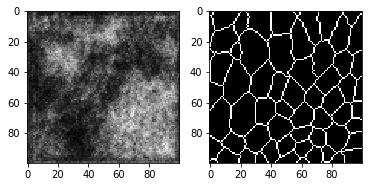

Estimate_g_m: -3.51612
Estimate_r_m: 12.422495
Estimate_g_v: 86.84734
Estimate_r_v: 4.586203
Iteration: 10 at 2018-02-22 19:14:25.562690


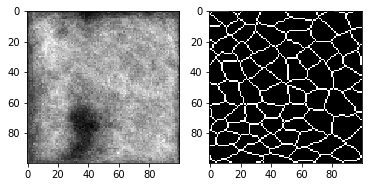

Estimate_g_m: -2.3463676
Estimate_r_m: 0.8345538
Estimate_g_v: 4.723275
Estimate_r_v: 0.45009872
Iteration: 20 at 2018-02-22 19:14:36.274705


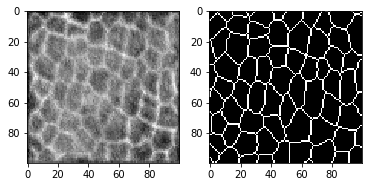

Estimate_g_m: 0.16059084
Estimate_r_m: 0.6223224
Estimate_g_v: 0.010927222
Estimate_r_v: 0.03501774
Iteration: 30 at 2018-02-22 19:14:46.954720


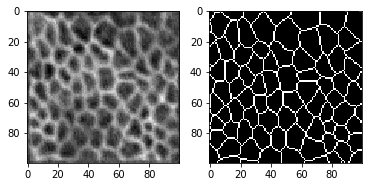

Estimate_g_m: -0.1161885
Estimate_r_m: 0.20063679
Estimate_g_v: 0.028698174
Estimate_r_v: 0.1340323
Iteration: 40 at 2018-02-22 19:14:57.966736


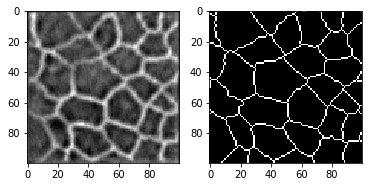

Estimate_g_m: 0.5799133
Estimate_r_m: -0.03252135
Estimate_g_v: 0.06052125
Estimate_r_v: 0.06921491
Iteration: 50 at 2018-02-22 19:15:08.786751


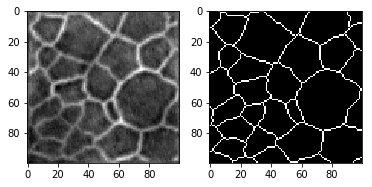

Estimate_g_m: 0.06653417
Estimate_r_m: 0.08186232
Estimate_g_v: 0.017518533
Estimate_r_v: 0.060873333
Iteration: 60 at 2018-02-22 19:15:19.696766


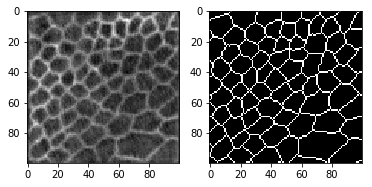

Estimate_g_m: -0.0005010763
Estimate_r_m: -0.04954279
Estimate_g_v: 0.0014269659
Estimate_r_v: 0.025032438
Iteration: 70 at 2018-02-22 19:15:30.668782


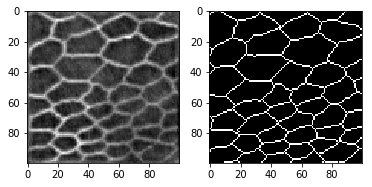

Estimate_g_m: -0.18654433
Estimate_r_m: 0.05726738
Estimate_g_v: 0.003596424
Estimate_r_v: 0.051280953
Iteration: 80 at 2018-02-22 19:15:41.708797


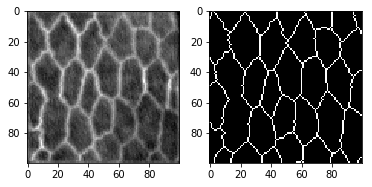

Estimate_g_m: -0.08336145
Estimate_r_m: 0.021158874
Estimate_g_v: 0.0038945011
Estimate_r_v: 0.03649172
Iteration: 90 at 2018-02-22 19:15:53.048813


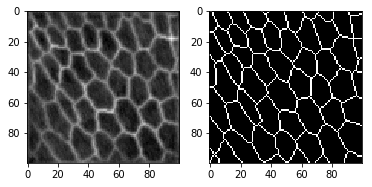

Estimate_g_m: 0.04361949
Estimate_r_m: 0.091605045
Estimate_g_v: 0.010013521
Estimate_r_v: 0.0588753
Iteration: 100 at 2018-02-22 19:16:04.020829


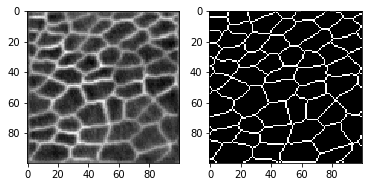

Estimate_g_m: -0.04681889
Estimate_r_m: -0.050295066
Estimate_g_v: 0.0067823767
Estimate_r_v: 0.03275091
Iteration: 110 at 2018-02-22 19:16:15.160844


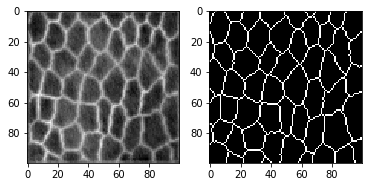

Estimate_g_m: -0.015658349
Estimate_r_m: -0.04171412
Estimate_g_v: 0.005983235
Estimate_r_v: 0.04326723
Iteration: 120 at 2018-02-22 19:16:26.362860


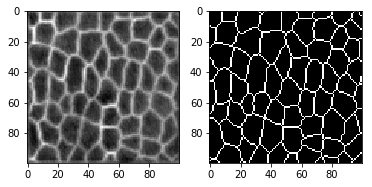

Estimate_g_m: -0.05706572
Estimate_r_m: -0.01453797
Estimate_g_v: 0.0067007453
Estimate_r_v: 0.047701135
Iteration: 130 at 2018-02-22 19:16:37.482875


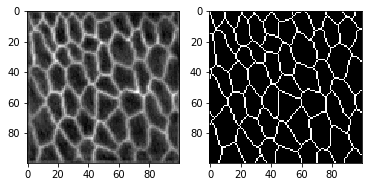

Estimate_g_m: 0.018215375
Estimate_r_m: 0.06923573
Estimate_g_v: 0.006359488
Estimate_r_v: 0.04392965
Iteration: 140 at 2018-02-22 19:16:49.072892


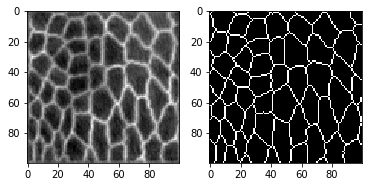

Estimate_g_m: -0.063313864
Estimate_r_m: 0.008423922
Estimate_g_v: 0.0105852345
Estimate_r_v: 0.052266188
Iteration: 150 at 2018-02-22 19:17:00.332907


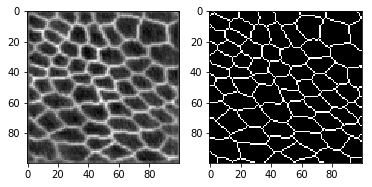

Estimate_g_m: -0.009912594
Estimate_r_m: 0.11077448
Estimate_g_v: 0.011862203
Estimate_r_v: 0.069100164
Iteration: 160 at 2018-02-22 19:17:11.482923


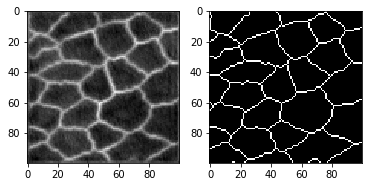

Estimate_g_m: -0.078902066
Estimate_r_m: 0.021825252
Estimate_g_v: 0.009570258
Estimate_r_v: 0.050196614
Iteration: 170 at 2018-02-22 19:17:22.592939


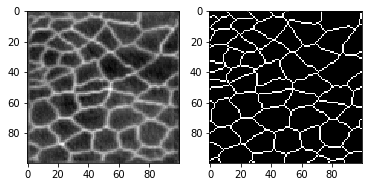

Estimate_g_m: -0.110946
Estimate_r_m: 0.028997201
Estimate_g_v: 0.010361709
Estimate_r_v: 0.082587354
Iteration: 180 at 2018-02-22 19:17:33.872954


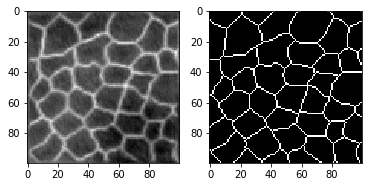

Estimate_g_m: -0.14125444
Estimate_r_m: -0.009182784
Estimate_g_v: 0.010291581
Estimate_r_v: 0.07319365
Iteration: 190 at 2018-02-22 19:17:45.042970


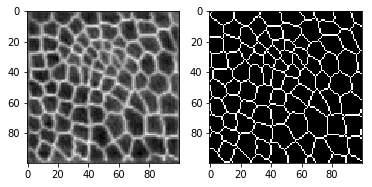

Estimate_g_m: 0.29974115
Estimate_r_m: 0.5772055
Estimate_g_v: 0.016381228
Estimate_r_v: 0.13757247
Iteration: 200 at 2018-02-22 19:17:56.242986


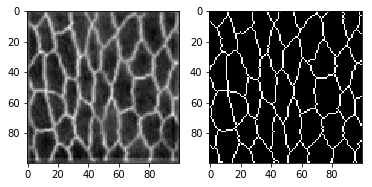

Estimate_g_m: -0.13162297
Estimate_r_m: 0.12849411
Estimate_g_v: 0.008746106
Estimate_r_v: 0.052150093
Iteration: 210 at 2018-02-22 19:18:07.873002


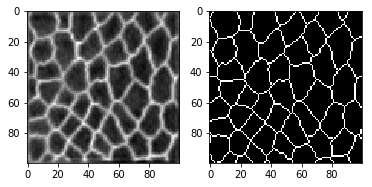

Estimate_g_m: -0.027039321
Estimate_r_m: -0.040185876
Estimate_g_v: 0.008874098
Estimate_r_v: 0.05037429
Iteration: 220 at 2018-02-22 19:18:19.003018


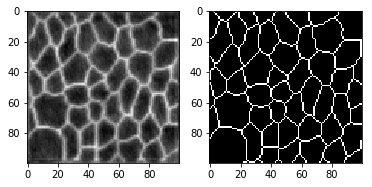

Estimate_g_m: 0.03143649
Estimate_r_m: 0.064766765
Estimate_g_v: 0.006954072
Estimate_r_v: 0.06374195
Iteration: 230 at 2018-02-22 19:18:30.323033


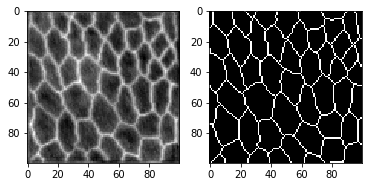

Estimate_g_m: 0.0024589822
Estimate_r_m: 0.13453504
Estimate_g_v: 0.0029575136
Estimate_r_v: 0.039804243
Iteration: 240 at 2018-02-22 19:18:41.533049


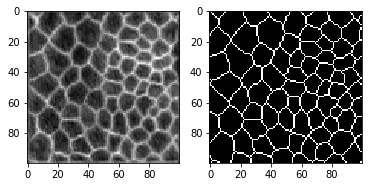

Estimate_g_m: -0.05772318
Estimate_r_m: -0.06576994
Estimate_g_v: 0.004200005
Estimate_r_v: 0.05389937
Iteration: 250 at 2018-02-22 19:18:52.773065


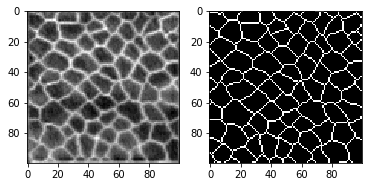

Estimate_g_m: -0.01496094
Estimate_r_m: 0.09725523
Estimate_g_v: 0.006239834
Estimate_r_v: 0.049979612
Iteration: 260 at 2018-02-22 19:19:03.965081


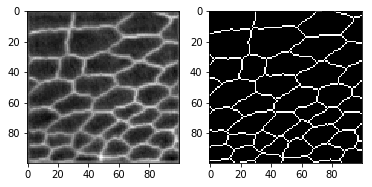

Estimate_g_m: 0.09316635
Estimate_r_m: 0.27854514
Estimate_g_v: 0.005928317
Estimate_r_v: 0.061445955
Iteration: 270 at 2018-02-22 19:19:15.195096


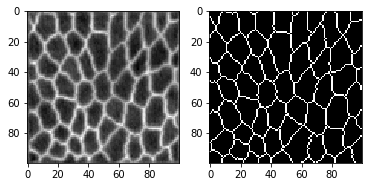

Estimate_g_m: -0.08325924
Estimate_r_m: -0.102324635
Estimate_g_v: 0.003169091
Estimate_r_v: 0.02150555
Iteration: 280 at 2018-02-22 19:19:26.867113


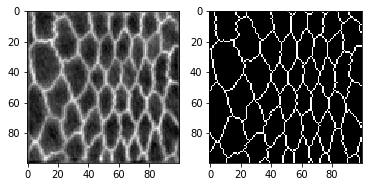

Estimate_g_m: -0.04155079
Estimate_r_m: 0.023556216
Estimate_g_v: 0.0021464014
Estimate_r_v: 0.03483547
Iteration: 290 at 2018-02-22 19:19:38.047128


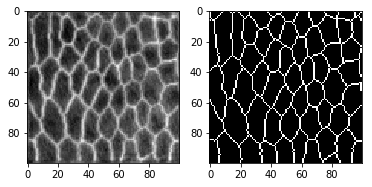

Estimate_g_m: 0.16048549
Estimate_r_m: 0.121529505
Estimate_g_v: 0.002798218
Estimate_r_v: 0.049765382
Iteration: 300 at 2018-02-22 19:19:49.507145


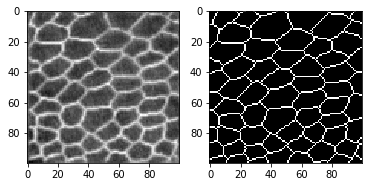

Estimate_g_m: -0.018553354
Estimate_r_m: 0.0388008
Estimate_g_v: 0.0031353866
Estimate_r_v: 0.02808483
Iteration: 310 at 2018-02-22 19:20:00.852161


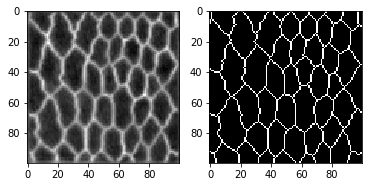

Estimate_g_m: -0.04763263
Estimate_r_m: -0.012749509
Estimate_g_v: 0.0053716833
Estimate_r_v: 0.035371035
Iteration: 320 at 2018-02-22 19:20:12.122177


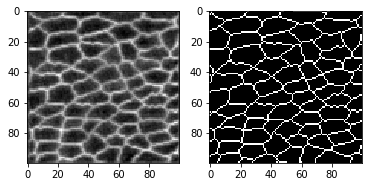

Estimate_g_m: -0.050033003
Estimate_r_m: -0.002015915
Estimate_g_v: 0.0015033451
Estimate_r_v: 0.00899701
Iteration: 330 at 2018-02-22 19:20:23.562193


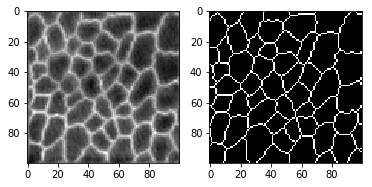

Estimate_g_m: -0.12286227
Estimate_r_m: 0.025731657
Estimate_g_v: 0.0034089603
Estimate_r_v: 0.037627034
Iteration: 340 at 2018-02-22 19:20:35.043209


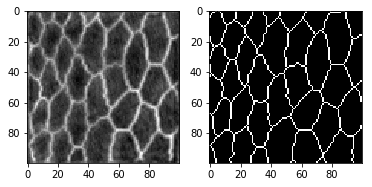

Estimate_g_m: -0.069016844
Estimate_r_m: -0.06390941
Estimate_g_v: 0.0016436861
Estimate_r_v: 0.012122892
Iteration: 350 at 2018-02-22 19:20:46.553225


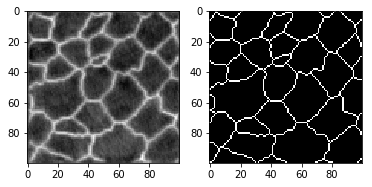

Estimate_g_m: -0.003775886
Estimate_r_m: 0.0046308856
Estimate_g_v: 0.0052474416
Estimate_r_v: 0.052616253
Iteration: 360 at 2018-02-22 19:20:57.989243


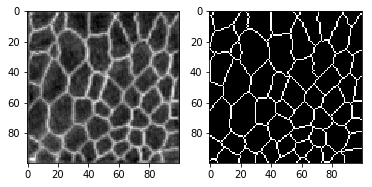

Estimate_g_m: 0.076272406
Estimate_r_m: 0.17125005
Estimate_g_v: 0.003142658
Estimate_r_v: 0.040079866
Iteration: 370 at 2018-02-22 19:21:09.930260


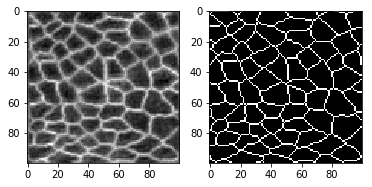

Estimate_g_m: 0.037647806
Estimate_r_m: 0.1562257
Estimate_g_v: 0.0017787372
Estimate_r_v: 0.013709491
Iteration: 380 at 2018-02-22 19:21:21.400276


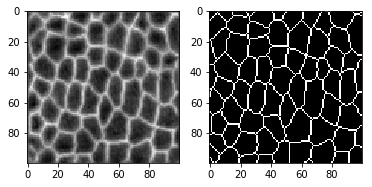

Estimate_g_m: -0.034492943
Estimate_r_m: 0.034809925
Estimate_g_v: 0.0089786975
Estimate_r_v: 0.0561453
Iteration: 390 at 2018-02-22 19:21:32.870292


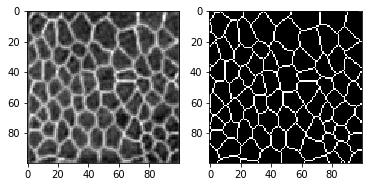

Estimate_g_m: -0.07004926
Estimate_r_m: -0.043660115
Estimate_g_v: 0.0028284902
Estimate_r_v: 0.03764229
Iteration: 400 at 2018-02-22 19:21:44.400308


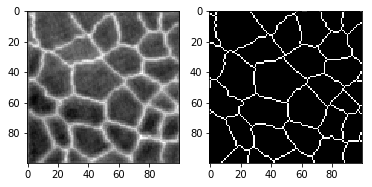

Estimate_g_m: -0.06284094
Estimate_r_m: -0.06980591
Estimate_g_v: 0.0022874137
Estimate_r_v: 0.014008339
Iteration: 410 at 2018-02-22 19:21:55.880324


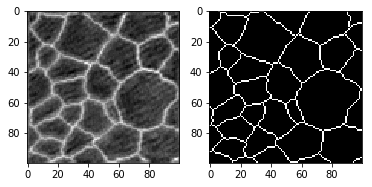

Estimate_g_m: 0.06795719
Estimate_r_m: 0.19220218
Estimate_g_v: 0.007244196
Estimate_r_v: 0.08340976
Iteration: 420 at 2018-02-22 19:22:07.360340


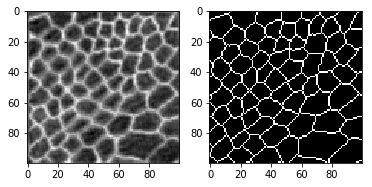

Estimate_g_m: 0.0023323933
Estimate_r_m: 0.13190581
Estimate_g_v: 0.0015020609
Estimate_r_v: 0.024609402
Iteration: 430 at 2018-02-22 19:22:18.830357


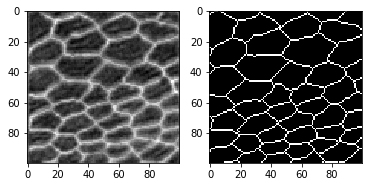

Estimate_g_m: -0.023914658
Estimate_r_m: 0.15701872
Estimate_g_v: 0.005898718
Estimate_r_v: 0.05823127
Iteration: 440 at 2018-02-22 19:22:30.360373


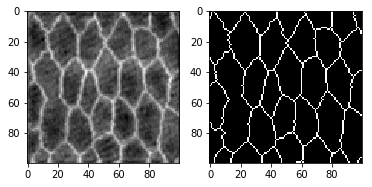

Estimate_g_m: 0.13861972
Estimate_r_m: 0.15136904
Estimate_g_v: 0.005595637
Estimate_r_v: 0.031507794
Iteration: 450 at 2018-02-22 19:22:41.880389


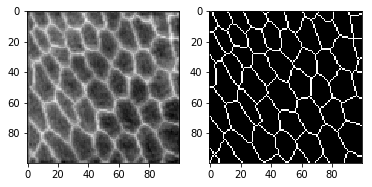

Estimate_g_m: 0.04146545
Estimate_r_m: 0.05743141
Estimate_g_v: 0.0151541075
Estimate_r_v: 0.07139316
Iteration: 460 at 2018-02-22 19:22:53.430405


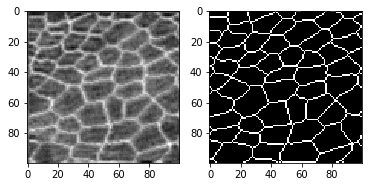

Estimate_g_m: -0.04302214
Estimate_r_m: -0.028952122
Estimate_g_v: 0.00563706
Estimate_r_v: 0.032941725
Iteration: 470 at 2018-02-22 19:23:05.800422


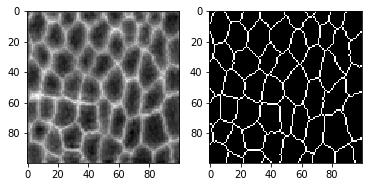

Estimate_g_m: -0.036347568
Estimate_r_m: 0.02651253
Estimate_g_v: 0.0024985105
Estimate_r_v: 0.034860507
Iteration: 480 at 2018-02-22 19:23:17.480439


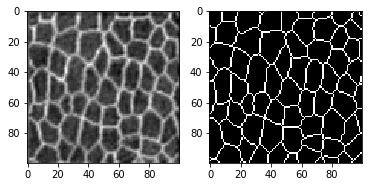

Estimate_g_m: 0.722137
Estimate_r_m: 0.69919616
Estimate_g_v: 0.013763848
Estimate_r_v: 0.20411906
Iteration: 490 at 2018-02-22 19:23:29.380455


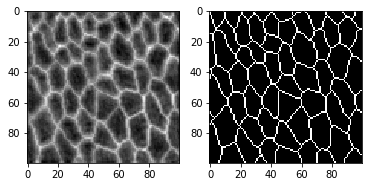

Estimate_g_m: 0.02376552
Estimate_r_m: 0.1410212
Estimate_g_v: 0.0051270085
Estimate_r_v: 0.052973747
Iteration: 500 at 2018-02-22 19:23:41.070472


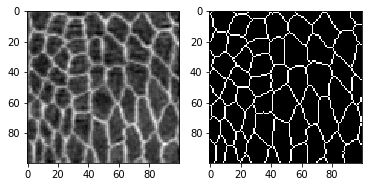

Estimate_g_m: 0.020584913
Estimate_r_m: 0.13100885
Estimate_g_v: 0.007164376
Estimate_r_v: 0.07382089
Iteration: 510 at 2018-02-22 19:23:52.740488


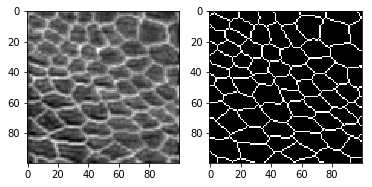

Estimate_g_m: 0.16506371
Estimate_r_m: 0.37057555
Estimate_g_v: 0.007702592
Estimate_r_v: 0.087912865
Iteration: 520 at 2018-02-22 19:24:04.490504


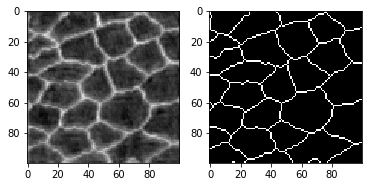

Estimate_g_m: -0.13921218
Estimate_r_m: 0.10837378
Estimate_g_v: 0.0036522564
Estimate_r_v: 0.03266635
Iteration: 530 at 2018-02-22 19:24:16.040521


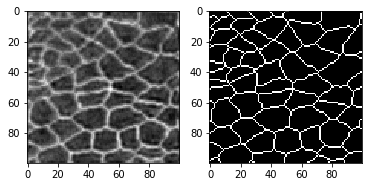

Estimate_g_m: -0.032019056
Estimate_r_m: 0.013899649
Estimate_g_v: 0.006049229
Estimate_r_v: 0.06941273
Iteration: 540 at 2018-02-22 19:24:27.830537


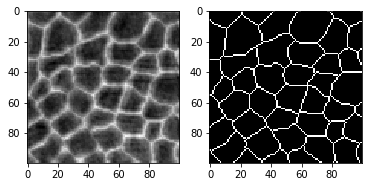

Estimate_g_m: -0.20953602
Estimate_r_m: -0.1744581
Estimate_g_v: 0.0042304555
Estimate_r_v: 0.013499875
Iteration: 550 at 2018-02-22 19:24:39.440553


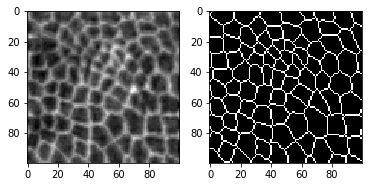

Estimate_g_m: 0.32945403
Estimate_r_m: 0.40407684
Estimate_g_v: 0.02099978
Estimate_r_v: 0.11271357
Iteration: 560 at 2018-02-22 19:24:51.120570


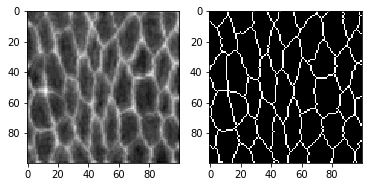

Estimate_g_m: -0.0959501
Estimate_r_m: -0.033752695
Estimate_g_v: 0.010110537
Estimate_r_v: 0.044408157
Iteration: 570 at 2018-02-22 19:25:02.890586


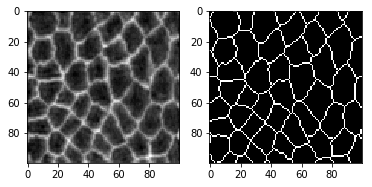

Estimate_g_m: 0.047496594
Estimate_r_m: 0.10908552
Estimate_g_v: 0.006792984
Estimate_r_v: 0.031764343
Iteration: 580 at 2018-02-22 19:25:15.330604


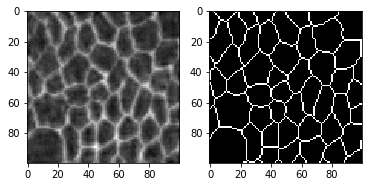

Estimate_g_m: 0.14002915
Estimate_r_m: 0.21489841
Estimate_g_v: 0.018241823
Estimate_r_v: 0.08696618
Iteration: 590 at 2018-02-22 19:25:26.980620


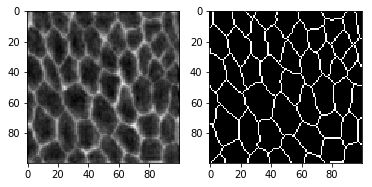

Estimate_g_m: -0.060371626
Estimate_r_m: 0.080900505
Estimate_g_v: 0.009449493
Estimate_r_v: 0.03403693
Iteration: 600 at 2018-02-22 19:25:38.640636


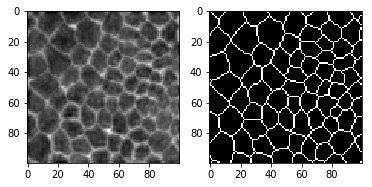

Estimate_g_m: -0.15484855
Estimate_r_m: -0.050913658
Estimate_g_v: 0.006724971
Estimate_r_v: 0.048227757
Iteration: 610 at 2018-02-22 19:25:50.440653


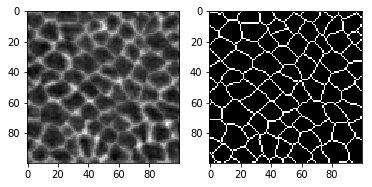

Estimate_g_m: -0.07089642
Estimate_r_m: 0.04209049
Estimate_g_v: 0.009649604
Estimate_r_v: 0.050206095
Iteration: 620 at 2018-02-22 19:26:02.300669


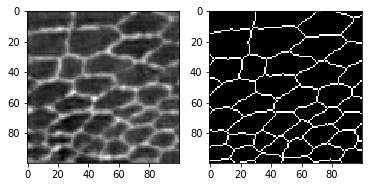

Estimate_g_m: 0.47124186
Estimate_r_m: 0.56532174
Estimate_g_v: 0.03519745
Estimate_r_v: 0.19840692
Iteration: 630 at 2018-02-22 19:26:13.930686


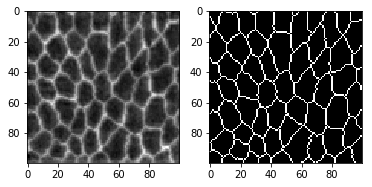

Estimate_g_m: 0.13789922
Estimate_r_m: 0.2936738
Estimate_g_v: 0.02003744
Estimate_r_v: 0.10694663
Iteration: 640 at 2018-02-22 19:26:25.700702


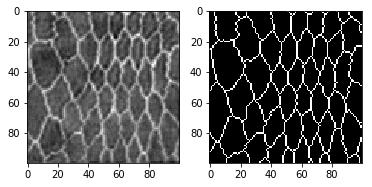

Estimate_g_m: 0.0677459
Estimate_r_m: 0.10438876
Estimate_g_v: 0.0025249275
Estimate_r_v: 0.020717345
Iteration: 650 at 2018-02-22 19:26:37.560719


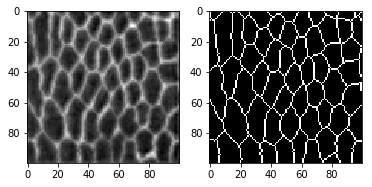

Estimate_g_m: -0.06405697
Estimate_r_m: 0.0029974955
Estimate_g_v: 0.019295778
Estimate_r_v: 0.06459896
Iteration: 660 at 2018-02-22 19:26:49.230735


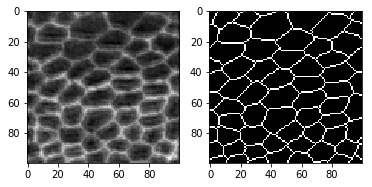

Estimate_g_m: 0.08152404
Estimate_r_m: 0.09175101
Estimate_g_v: 0.0075209467
Estimate_r_v: 0.023530176
Iteration: 670 at 2018-02-22 19:27:01.160752


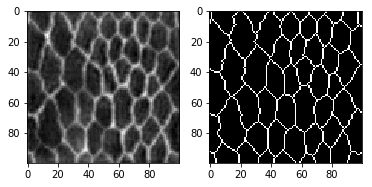

Estimate_g_m: -0.067478165
Estimate_r_m: 0.034260787
Estimate_g_v: 0.014157598
Estimate_r_v: 0.039518125
Iteration: 680 at 2018-02-22 19:27:12.990768


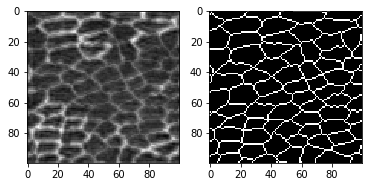

Estimate_g_m: -0.029950643
Estimate_r_m: 0.10413867
Estimate_g_v: 0.026135324
Estimate_r_v: 0.09277256
Iteration: 690 at 2018-02-22 19:27:24.980785


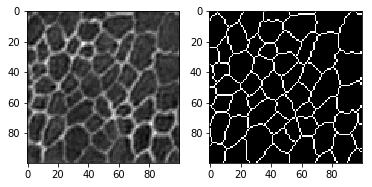

Estimate_g_m: 0.13545464
Estimate_r_m: 0.49942183
Estimate_g_v: 0.03823049
Estimate_r_v: 0.15169223
Iteration: 700 at 2018-02-22 19:27:36.920802


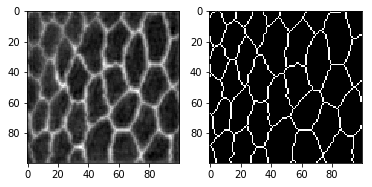

Estimate_g_m: 0.110878125
Estimate_r_m: 0.23921001
Estimate_g_v: 0.035972167
Estimate_r_v: 0.08549674
Iteration: 710 at 2018-02-22 19:27:48.770818


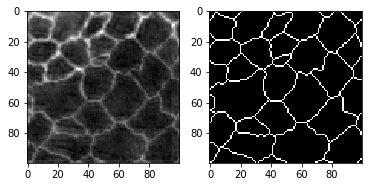

Estimate_g_m: 0.0043679145
Estimate_r_m: 0.12338186
Estimate_g_v: 0.011535729
Estimate_r_v: 0.025936177
Iteration: 720 at 2018-02-22 19:28:01.650836


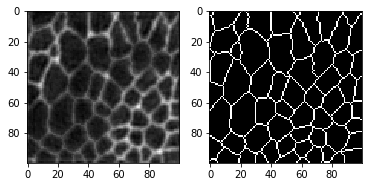

Estimate_g_m: -0.08185785
Estimate_r_m: 0.041946024
Estimate_g_v: 0.054172
Estimate_r_v: 0.11313693
Iteration: 730 at 2018-02-22 19:28:13.590853


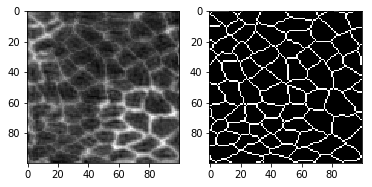

Estimate_g_m: -0.036214326
Estimate_r_m: -0.020834107
Estimate_g_v: 0.017678956
Estimate_r_v: 0.015162924
Iteration: 740 at 2018-02-22 19:28:25.550870


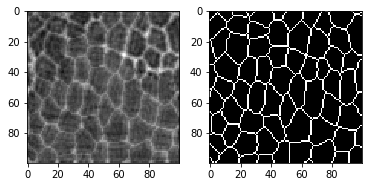

Estimate_g_m: 0.17148052
Estimate_r_m: 0.13841586
Estimate_g_v: 0.019388663
Estimate_r_v: 0.03674652
Iteration: 750 at 2018-02-22 19:28:37.620887


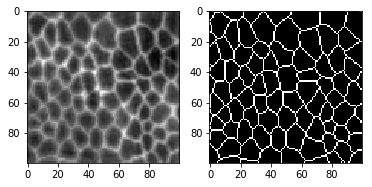

Estimate_g_m: -0.40646875
Estimate_r_m: -0.22709845
Estimate_g_v: 0.0528542
Estimate_r_v: 0.16546725
Iteration: 760 at 2018-02-22 19:28:49.540904


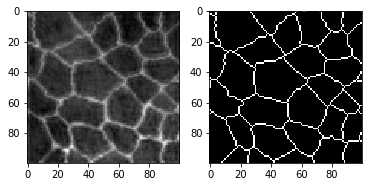

Estimate_g_m: 0.025168529
Estimate_r_m: 0.2623533
Estimate_g_v: 0.025206123
Estimate_r_v: 0.10468306
Iteration: 770 at 2018-02-22 19:29:01.480920


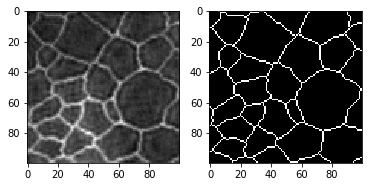

Estimate_g_m: -0.03811467
Estimate_r_m: 0.19313821
Estimate_g_v: 0.011815846
Estimate_r_v: 0.08578018
Iteration: 780 at 2018-02-22 19:29:13.410937


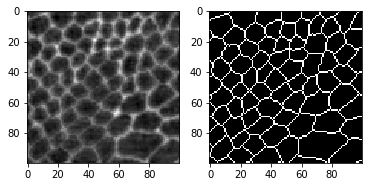

Estimate_g_m: -0.22808076
Estimate_r_m: 0.011215619
Estimate_g_v: 0.057151593
Estimate_r_v: 0.15909939
Iteration: 790 at 2018-02-22 19:29:25.340954


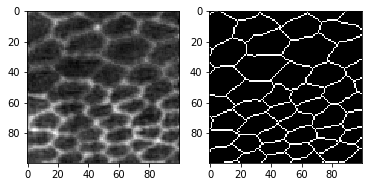

Estimate_g_m: 0.15856914
Estimate_r_m: 0.26799157
Estimate_g_v: 0.035462003
Estimate_r_v: 0.14956242
Iteration: 800 at 2018-02-22 19:29:37.230970


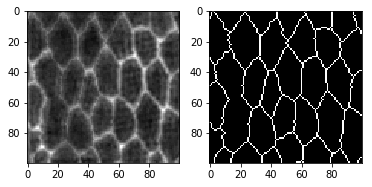

Estimate_g_m: -0.13179304
Estimate_r_m: 0.016468221
Estimate_g_v: 0.034075446
Estimate_r_v: 0.040857244
Iteration: 810 at 2018-02-22 19:29:49.260987


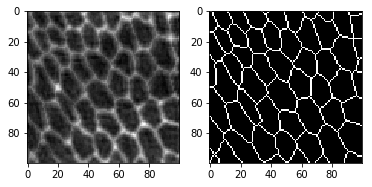

Estimate_g_m: 0.0108583
Estimate_r_m: 0.1166941
Estimate_g_v: 0.026104823
Estimate_r_v: 0.059269596
Iteration: 820 at 2018-02-22 19:30:01.241004


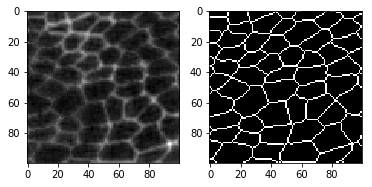

Estimate_g_m: 0.039299175
Estimate_r_m: 0.09763691
Estimate_g_v: 0.033502035
Estimate_r_v: 0.029923517
Iteration: 830 at 2018-02-22 19:30:13.201021


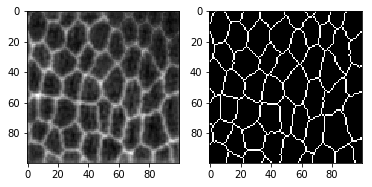

Estimate_g_m: -0.012945744
Estimate_r_m: 0.17933853
Estimate_g_v: 0.015865736
Estimate_r_v: 0.0524269
Iteration: 840 at 2018-02-22 19:30:25.221037


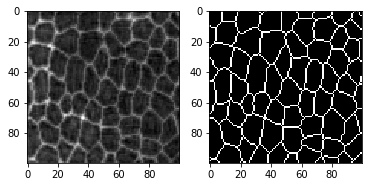

Estimate_g_m: -0.07485054
Estimate_r_m: 0.16665772
Estimate_g_v: 0.023350753
Estimate_r_v: 0.07306882
Iteration: 850 at 2018-02-22 19:30:37.401055


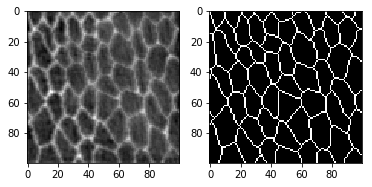

Estimate_g_m: 0.013529693
Estimate_r_m: 0.3257435
Estimate_g_v: 0.024584895
Estimate_r_v: 0.18691485
Iteration: 860 at 2018-02-22 19:30:49.671072


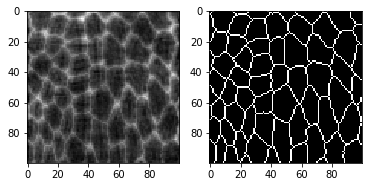

Estimate_g_m: -0.024201263
Estimate_r_m: 0.067489885
Estimate_g_v: 0.07274357
Estimate_r_v: 0.18863678
Iteration: 870 at 2018-02-22 19:31:01.814089


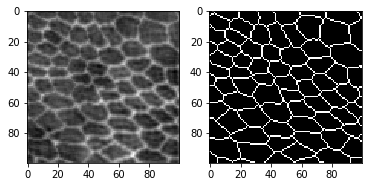

Estimate_g_m: -0.083732255
Estimate_r_m: 0.26779136
Estimate_g_v: 0.022924671
Estimate_r_v: 0.15067105
Iteration: 880 at 2018-02-22 19:31:14.584107


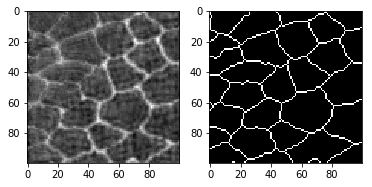

Estimate_g_m: -0.15530281
Estimate_r_m: -0.23041676
Estimate_g_v: 0.03354073
Estimate_r_v: 0.0786517
Iteration: 890 at 2018-02-22 19:31:26.665125


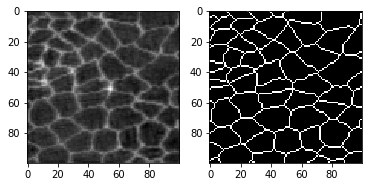

Estimate_g_m: -0.2785436
Estimate_r_m: 0.00876878
Estimate_g_v: 0.061448015
Estimate_r_v: 0.2887938
Iteration: 900 at 2018-02-22 19:31:38.686142


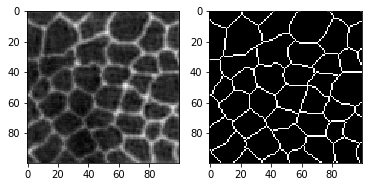

Estimate_g_m: 0.008575434
Estimate_r_m: 0.21769205
Estimate_g_v: 0.059059717
Estimate_r_v: 0.056498546
Iteration: 910 at 2018-02-22 19:31:50.696159


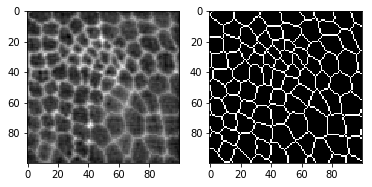

Estimate_g_m: -0.4637009
Estimate_r_m: 0.08719288
Estimate_g_v: 0.06023769
Estimate_r_v: 0.5364281
Iteration: 920 at 2018-02-22 19:32:02.846176


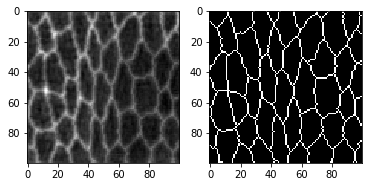

Estimate_g_m: -0.0045603733
Estimate_r_m: 0.32042557
Estimate_g_v: 0.07108037
Estimate_r_v: 0.14094126
Iteration: 930 at 2018-02-22 19:32:14.936193


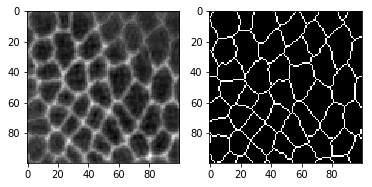

Estimate_g_m: 0.085349195
Estimate_r_m: 0.46522456
Estimate_g_v: 0.1290567
Estimate_r_v: 0.24868904
Iteration: 940 at 2018-02-22 19:32:27.218210


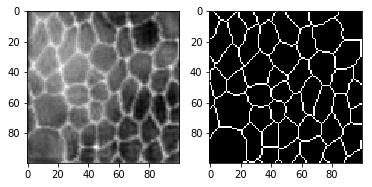

Estimate_g_m: -1.2559044
Estimate_r_m: 0.24024482
Estimate_g_v: 1.5149072
Estimate_r_v: 0.18430725
Iteration: 950 at 2018-02-22 19:32:39.378227


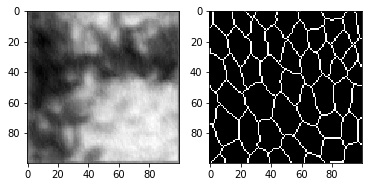

Estimate_g_m: -3.696357
Estimate_r_m: -1.760578
Estimate_g_v: 5.4157314
Estimate_r_v: 0.3150217
Iteration: 960 at 2018-02-22 19:32:51.528244


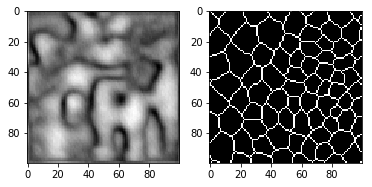

Estimate_g_m: -0.098661035
Estimate_r_m: -0.051055964
Estimate_g_v: 0.00034524006
Estimate_r_v: 0.0043584653
Iteration: 970 at 2018-02-22 19:33:03.820262


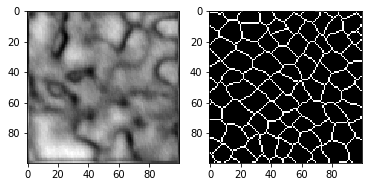

Estimate_g_m: 0.0079889195
Estimate_r_m: 0.0574851
Estimate_g_v: 0.048428956
Estimate_r_v: 0.2843935
Iteration: 980 at 2018-02-22 19:33:16.030279


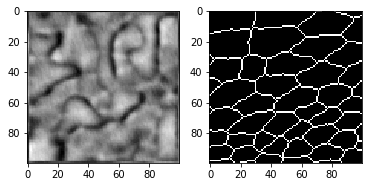

Estimate_g_m: 0.11663948
Estimate_r_m: 0.4489632
Estimate_g_v: 0.0051820786
Estimate_r_v: 0.031968627
Iteration: 990 at 2018-02-22 19:33:28.332296


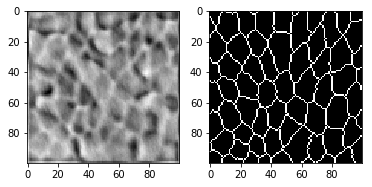

Estimate_g_m: -0.14716826
Estimate_r_m: 0.04950261
Estimate_g_v: 0.007589472
Estimate_r_v: 0.071511306
Iteration: 1000 at 2018-02-22 19:33:40.602313


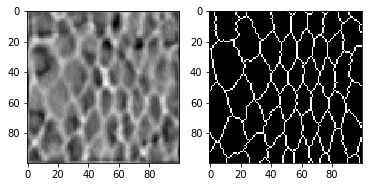

Estimate_g_m: 0.4771653
Estimate_r_m: 0.8632986
Estimate_g_v: 0.004241885
Estimate_r_v: 0.114425585
Iteration: 1010 at 2018-02-22 19:33:53.042331


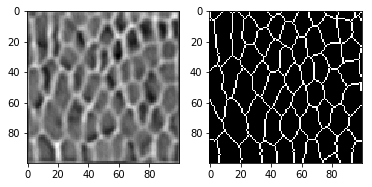

Estimate_g_m: -0.13280992
Estimate_r_m: 0.15903844
Estimate_g_v: 0.013477266
Estimate_r_v: 0.46399915
Iteration: 1020 at 2018-02-22 19:34:05.364348


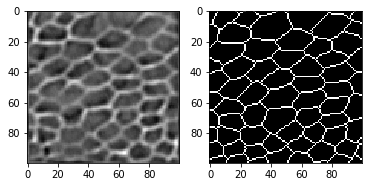

Estimate_g_m: -0.20811127
Estimate_r_m: -0.23413406
Estimate_g_v: 0.005299803
Estimate_r_v: 0.07263437
Iteration: 1030 at 2018-02-22 19:34:18.084366


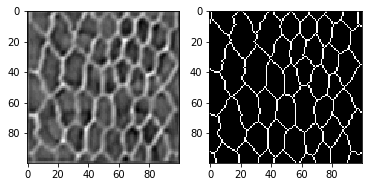

Estimate_g_m: 0.12420763
Estimate_r_m: 0.09617547
Estimate_g_v: 0.004080219
Estimate_r_v: 0.12799503
Iteration: 1040 at 2018-02-22 19:34:30.446383


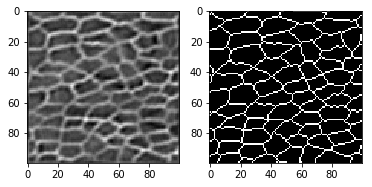

Estimate_g_m: -0.14673692
Estimate_r_m: -0.20460959
Estimate_g_v: 0.0005855702
Estimate_r_v: 0.022538804
Iteration: 1050 at 2018-02-22 19:34:42.706400


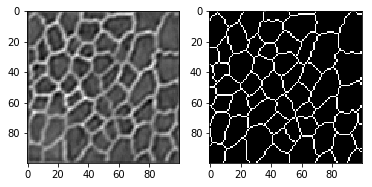

Estimate_g_m: 0.0787176
Estimate_r_m: 0.31945258
Estimate_g_v: 0.001408676
Estimate_r_v: 0.09177225
Iteration: 1060 at 2018-02-22 19:34:56.038419


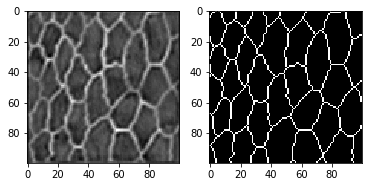

Estimate_g_m: -0.12774453
Estimate_r_m: -0.1822781
Estimate_g_v: 0.00042181477
Estimate_r_v: 0.009112479
Iteration: 1070 at 2018-02-22 19:35:08.458437


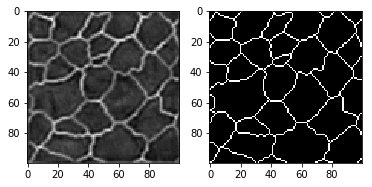

Estimate_g_m: 0.015253638
Estimate_r_m: 0.055811137
Estimate_g_v: 0.0009441327
Estimate_r_v: 0.01718621
Iteration: 1080 at 2018-02-22 19:35:20.768454


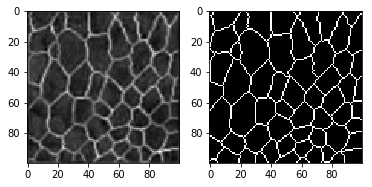

Estimate_g_m: -0.049762152
Estimate_r_m: 0.0023678548
Estimate_g_v: 0.001725388
Estimate_r_v: 0.072037995
Iteration: 1090 at 2018-02-22 19:35:33.189471


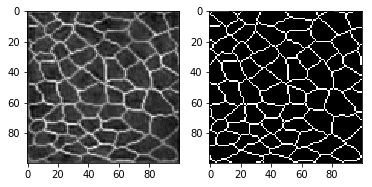

Estimate_g_m: -0.087835856
Estimate_r_m: 0.032228176
Estimate_g_v: 0.00080388656
Estimate_r_v: 0.026901541
Iteration: 1100 at 2018-02-22 19:35:45.459489


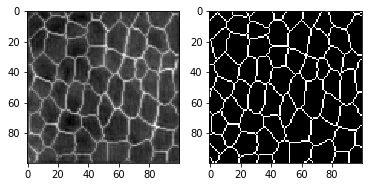

Estimate_g_m: -0.0800145
Estimate_r_m: 0.042709775
Estimate_g_v: 0.016898446
Estimate_r_v: 0.0795625
Iteration: 1110 at 2018-02-22 19:35:57.870506


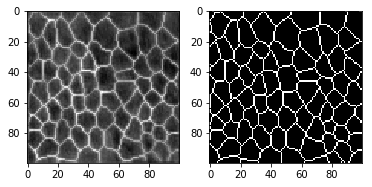

Estimate_g_m: -0.13771176
Estimate_r_m: -0.094449684
Estimate_g_v: 0.0033803221
Estimate_r_v: 0.022408238
Iteration: 1120 at 2018-02-22 19:36:10.340523


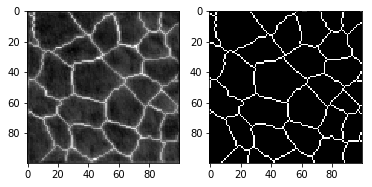

Estimate_g_m: 0.07545856
Estimate_r_m: 0.25603044
Estimate_g_v: 0.0024031932
Estimate_r_v: 0.032679003
Iteration: 1130 at 2018-02-22 19:36:22.680541


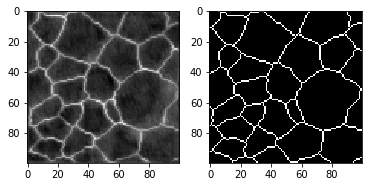

Estimate_g_m: -0.26365778
Estimate_r_m: -0.08459778
Estimate_g_v: 0.0017441794
Estimate_r_v: 0.072067164
Iteration: 1140 at 2018-02-22 19:36:34.961558


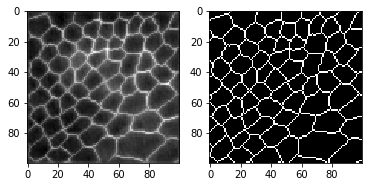

Estimate_g_m: 0.09361057
Estimate_r_m: 0.35734147
Estimate_g_v: 0.11713056
Estimate_r_v: 0.16475199
Iteration: 1150 at 2018-02-22 19:36:47.561576


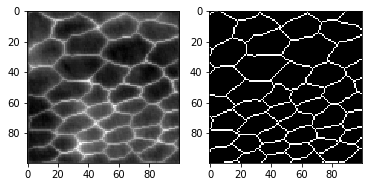

Estimate_g_m: 0.13855588
Estimate_r_m: 0.15068546
Estimate_g_v: 0.08727906
Estimate_r_v: 0.06463283
Iteration: 1160 at 2018-02-22 19:36:59.872593


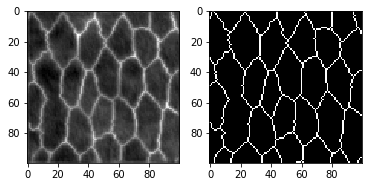

Estimate_g_m: -0.19706623
Estimate_r_m: 0.014440209
Estimate_g_v: 0.006414361
Estimate_r_v: 0.10962217
Iteration: 1170 at 2018-02-22 19:37:12.572611


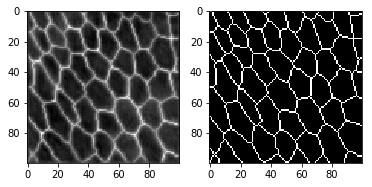

Estimate_g_m: -0.17176722
Estimate_r_m: 0.14485465
Estimate_g_v: 0.005688216
Estimate_r_v: 0.08980118
Iteration: 1180 at 2018-02-22 19:37:25.052628


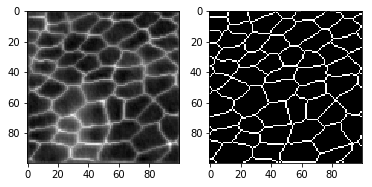

Estimate_g_m: 0.0022818819
Estimate_r_m: 0.024594758
Estimate_g_v: 0.050741106
Estimate_r_v: 0.105615616
Iteration: 1190 at 2018-02-22 19:37:37.633646


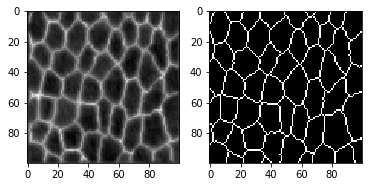

Estimate_g_m: -0.3357408
Estimate_r_m: -0.20092005
Estimate_g_v: 0.010803417
Estimate_r_v: 0.07502167
Iteration: 1200 at 2018-02-22 19:37:50.043663


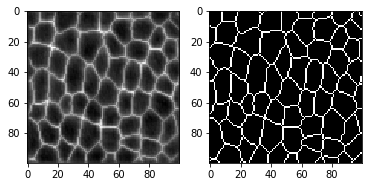

Estimate_g_m: -0.09358372
Estimate_r_m: 0.09848754
Estimate_g_v: 0.034119524
Estimate_r_v: 0.15680246
Iteration: 1210 at 2018-02-22 19:38:02.563681


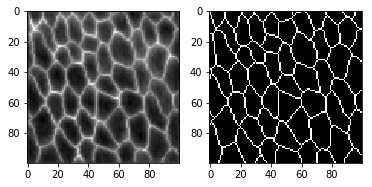

Estimate_g_m: 0.024315095
Estimate_r_m: 0.15530162
Estimate_g_v: 0.036081277
Estimate_r_v: 0.10631462
Iteration: 1220 at 2018-02-22 19:38:14.963698


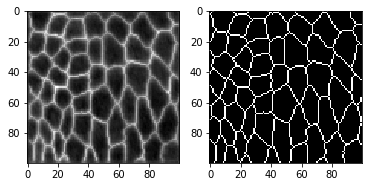

Estimate_g_m: 0.009053199
Estimate_r_m: 0.17775169
Estimate_g_v: 0.0802645
Estimate_r_v: 0.08381525
Iteration: 1230 at 2018-02-22 19:38:27.593716


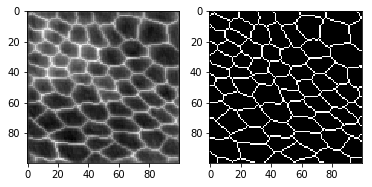

Estimate_g_m: -0.019867461
Estimate_r_m: 0.19331147
Estimate_g_v: 0.17489523
Estimate_r_v: 0.34854066
Iteration: 1240 at 2018-02-22 19:38:40.083733


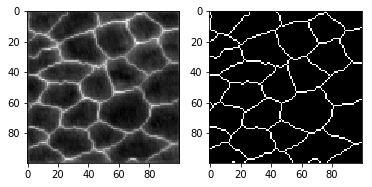

Estimate_g_m: -0.1334456
Estimate_r_m: 0.03527694
Estimate_g_v: 0.07041451
Estimate_r_v: 0.102479935
Iteration: 1250 at 2018-02-22 19:38:52.593751


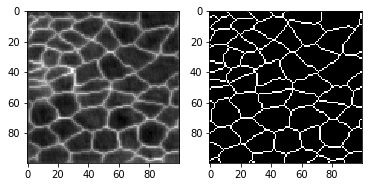

Estimate_g_m: -0.03449533
Estimate_r_m: 0.26430467
Estimate_g_v: 0.04418186
Estimate_r_v: 0.22603664
Iteration: 1260 at 2018-02-22 19:39:05.143768


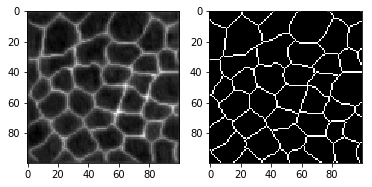

Estimate_g_m: 0.036681127
Estimate_r_m: 0.10334022
Estimate_g_v: 0.047191348
Estimate_r_v: 0.068246
Iteration: 1270 at 2018-02-22 19:39:17.703786


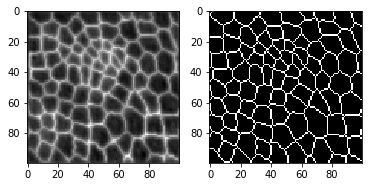

Estimate_g_m: 0.06551457
Estimate_r_m: 0.41062653
Estimate_g_v: 0.11096278
Estimate_r_v: 0.3865202
Iteration: 1280 at 2018-02-22 19:39:31.425805


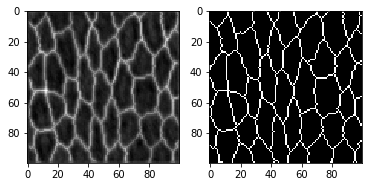

Estimate_g_m: -0.45712999
Estimate_r_m: -0.2623497
Estimate_g_v: 0.012868664
Estimate_r_v: 0.049742676
Iteration: 1290 at 2018-02-22 19:39:44.075823


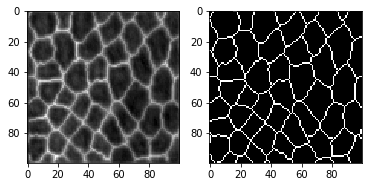

Estimate_g_m: -0.3728245
Estimate_r_m: -0.13884117
Estimate_g_v: 0.017136123
Estimate_r_v: 0.066581994
Iteration: 1300 at 2018-02-22 19:39:56.706841


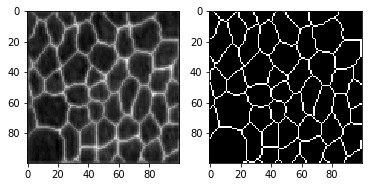

Estimate_g_m: -0.1398371
Estimate_r_m: 0.16736893
Estimate_g_v: 0.12109236
Estimate_r_v: 0.43299305
Iteration: 1310 at 2018-02-22 19:40:09.306859


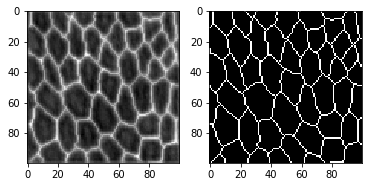

Estimate_g_m: 0.3868329
Estimate_r_m: 0.7411619
Estimate_g_v: 0.08124686
Estimate_r_v: 0.28885373
Iteration: 1320 at 2018-02-22 19:40:22.026877


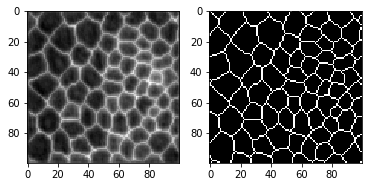

Estimate_g_m: -0.3487572
Estimate_r_m: -0.015756056
Estimate_g_v: 0.069514856
Estimate_r_v: 0.28794852
Iteration: 1330 at 2018-02-22 19:40:34.917895


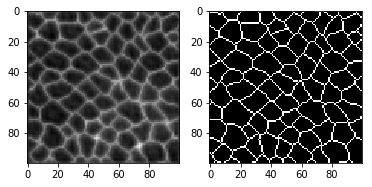

Estimate_g_m: -0.28593796
Estimate_r_m: -0.003036416
Estimate_g_v: 0.050725926
Estimate_r_v: 0.15544157
Iteration: 1340 at 2018-02-22 19:40:47.487913


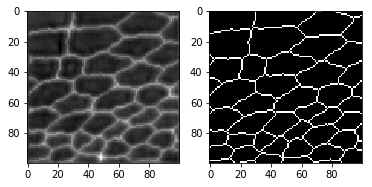

Estimate_g_m: -0.036703203
Estimate_r_m: 0.5737536
Estimate_g_v: 0.1539303
Estimate_r_v: 0.6632292
Iteration: 1350 at 2018-02-22 19:41:00.250931


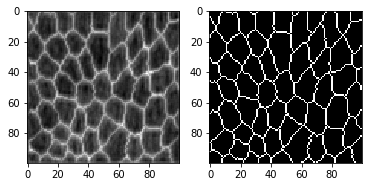

Estimate_g_m: 0.04084985
Estimate_r_m: 0.31390283
Estimate_g_v: 0.051900286
Estimate_r_v: 0.17253909
Iteration: 1360 at 2018-02-22 19:41:13.100949


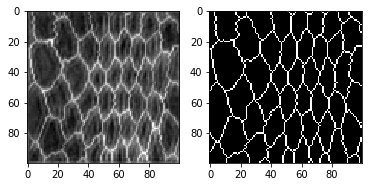

Estimate_g_m: 0.008180559
Estimate_r_m: 0.19742939
Estimate_g_v: 0.21046536
Estimate_r_v: 0.3064503
Iteration: 1370 at 2018-02-22 19:41:25.930967


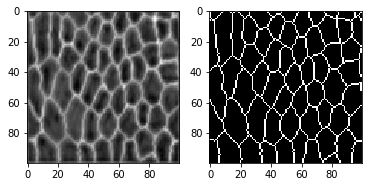

Estimate_g_m: -0.26735437
Estimate_r_m: 0.20535931
Estimate_g_v: 0.03495433
Estimate_r_v: 0.43669614
Iteration: 1380 at 2018-02-22 19:41:38.790985


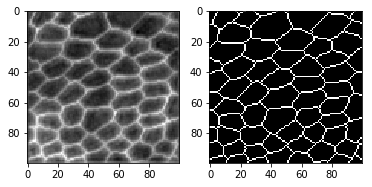

Estimate_g_m: -0.15899116
Estimate_r_m: 0.18727121
Estimate_g_v: 0.15355253
Estimate_r_v: 0.20419155
Iteration: 1390 at 2018-02-22 19:41:51.391003


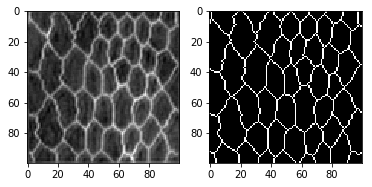

Estimate_g_m: -0.33670166
Estimate_r_m: 0.10772226
Estimate_g_v: 0.112583235
Estimate_r_v: 0.24141937
Iteration: 1400 at 2018-02-22 19:42:04.372022


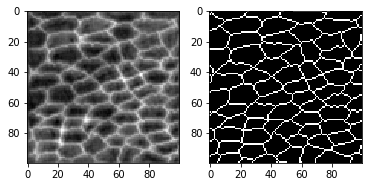

Estimate_g_m: -0.48723966
Estimate_r_m: 0.48040456
Estimate_g_v: 0.17697798
Estimate_r_v: 0.5327491
Iteration: 1410 at 2018-02-22 19:42:17.182040


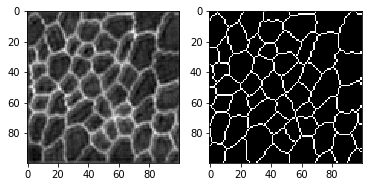

Estimate_g_m: -0.04247613
Estimate_r_m: 0.527115
Estimate_g_v: 0.127487
Estimate_r_v: 0.48912895
Iteration: 1420 at 2018-02-22 19:42:30.053058


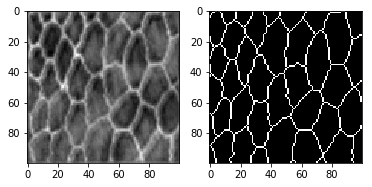

Estimate_g_m: -1.0505108
Estimate_r_m: -0.024300618
Estimate_g_v: 0.03517805
Estimate_r_v: 0.80894417
Iteration: 1430 at 2018-02-22 19:42:43.123077


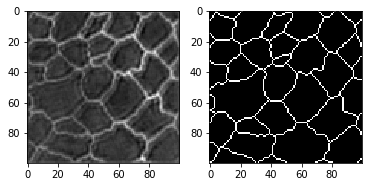

Estimate_g_m: -0.15254037
Estimate_r_m: 0.14289232
Estimate_g_v: 0.06697429
Estimate_r_v: 0.28478006
Iteration: 1440 at 2018-02-22 19:42:56.054095


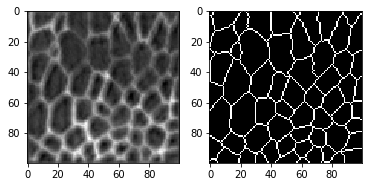

Estimate_g_m: -0.09727897
Estimate_r_m: 0.0917743
Estimate_g_v: 0.21151619
Estimate_r_v: 0.48647323
Iteration: 1450 at 2018-02-22 19:43:09.134114


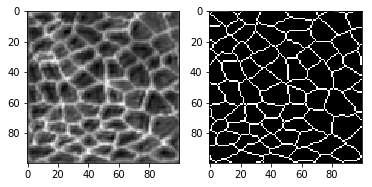

Estimate_g_m: -0.063527524
Estimate_r_m: 0.26539555
Estimate_g_v: 0.13510364
Estimate_r_v: 0.33723605
Iteration: 1460 at 2018-02-22 19:43:21.994132


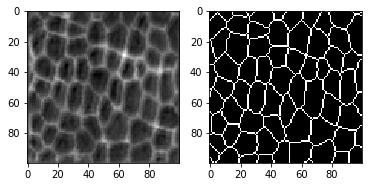

Estimate_g_m: -0.025947476
Estimate_r_m: 0.14284524
Estimate_g_v: 0.41825488
Estimate_r_v: 0.6265809
Iteration: 1470 at 2018-02-22 19:43:34.855150


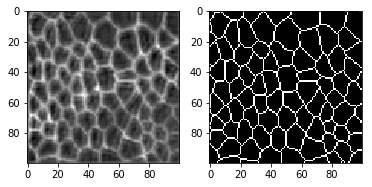

Estimate_g_m: 0.0752671
Estimate_r_m: 0.2559835
Estimate_g_v: 0.20790243
Estimate_r_v: 0.3043493
Iteration: 1480 at 2018-02-22 19:43:47.845169


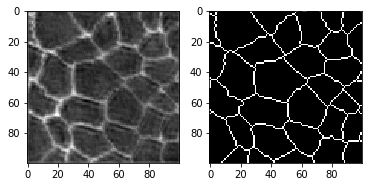

Estimate_g_m: -0.058767386
Estimate_r_m: 0.207236
Estimate_g_v: 0.14551811
Estimate_r_v: 0.16251066
Iteration: 1490 at 2018-02-22 19:44:00.836187


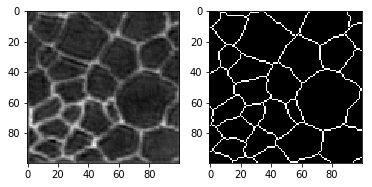

Estimate_g_m: -0.1990814
Estimate_r_m: 0.3325709
Estimate_g_v: 0.21714714
Estimate_r_v: 0.32674056
Iteration: 1500 at 2018-02-22 19:44:13.926206


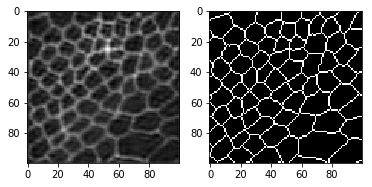

Estimate_g_m: -0.21655886
Estimate_r_m: 0.05572959
Estimate_g_v: 0.06841064
Estimate_r_v: 0.1195468
Iteration: 1510 at 2018-02-22 19:44:26.887224


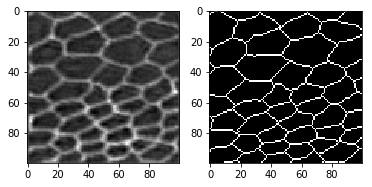

Estimate_g_m: 0.012951207
Estimate_r_m: 0.07752965
Estimate_g_v: 0.0610301
Estimate_r_v: 0.3114668
Iteration: 1520 at 2018-02-22 19:44:39.927243


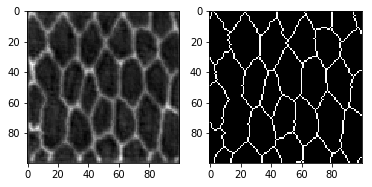

Estimate_g_m: -0.08483346
Estimate_r_m: 0.105250925
Estimate_g_v: 0.012669453
Estimate_r_v: 0.07767462
Iteration: 1530 at 2018-02-22 19:44:53.987262


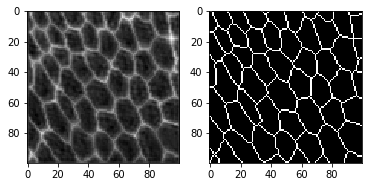

Estimate_g_m: -0.16600072
Estimate_r_m: 0.19589554
Estimate_g_v: 0.08899315
Estimate_r_v: 0.33299312
Iteration: 1540 at 2018-02-22 19:45:06.908281


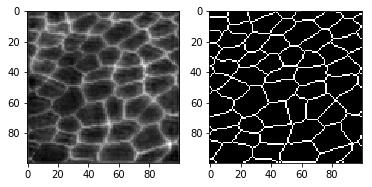

Estimate_g_m: -0.16021958
Estimate_r_m: 0.06875502
Estimate_g_v: 0.0740111
Estimate_r_v: 0.09997059
Iteration: 1550 at 2018-02-22 19:45:19.928299


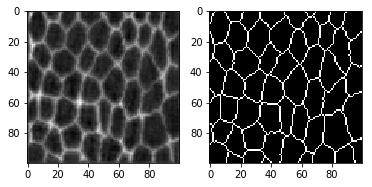

Estimate_g_m: -0.3264772
Estimate_r_m: -0.09137756
Estimate_g_v: 0.03783825
Estimate_r_v: 0.20719567
Iteration: 1560 at 2018-02-22 19:45:32.859318


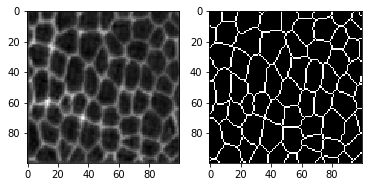

Estimate_g_m: -0.21437903
Estimate_r_m: 0.13286136
Estimate_g_v: 0.04642408
Estimate_r_v: 0.20556615
Iteration: 1570 at 2018-02-22 19:45:46.209337


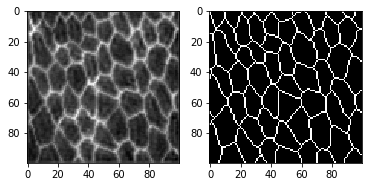

Estimate_g_m: -0.064473905
Estimate_r_m: 0.42085508
Estimate_g_v: 0.0839183
Estimate_r_v: 0.5179134
Iteration: 1580 at 2018-02-22 19:45:59.233356


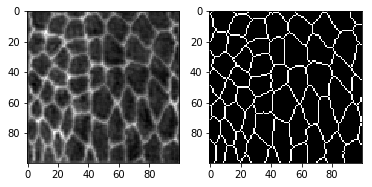

Estimate_g_m: -0.48270744
Estimate_r_m: -0.12078793
Estimate_g_v: 0.08826133
Estimate_r_v: 0.41331443
Iteration: 1590 at 2018-02-22 19:46:12.303374


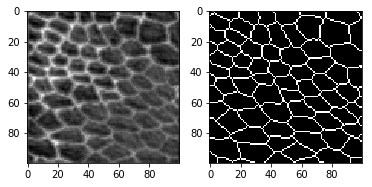

Estimate_g_m: -0.24838284
Estimate_r_m: 0.41180056
Estimate_g_v: 0.08294663
Estimate_r_v: 0.37367967
Iteration: 1600 at 2018-02-22 19:46:25.223392


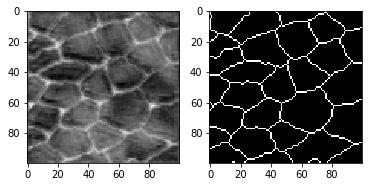

Estimate_g_m: -0.09442109
Estimate_r_m: 1.0014256
Estimate_g_v: 0.35861984
Estimate_r_v: 0.9127905
Iteration: 1610 at 2018-02-22 19:46:38.682411


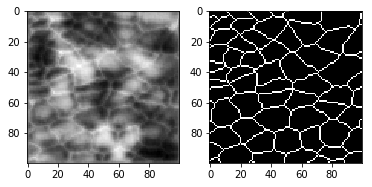

Estimate_g_m: -3.4426577
Estimate_r_m: 3.0954785
Estimate_g_v: 15.954555
Estimate_r_v: 5.704558
Iteration: 1620 at 2018-02-22 19:46:51.982430


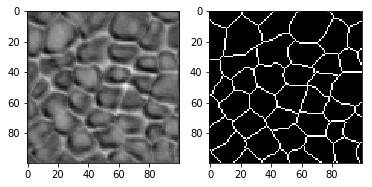

Estimate_g_m: 0.1003852
Estimate_r_m: 0.1023049
Estimate_g_v: 0.08510099
Estimate_r_v: 0.076921865
Iteration: 1630 at 2018-02-22 19:47:05.156449


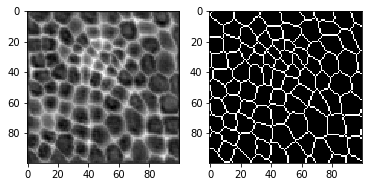

Estimate_g_m: -0.16640529
Estimate_r_m: -0.13963397
Estimate_g_v: 0.050144386
Estimate_r_v: 0.5124991
Iteration: 1640 at 2018-02-22 19:47:18.386468


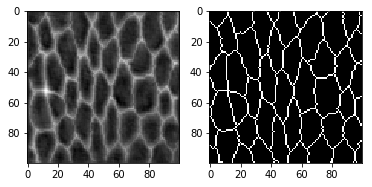

Estimate_g_m: -0.11116931
Estimate_r_m: -0.04172121
Estimate_g_v: 0.025508165
Estimate_r_v: 0.06684484
Iteration: 1650 at 2018-02-22 19:47:31.416486


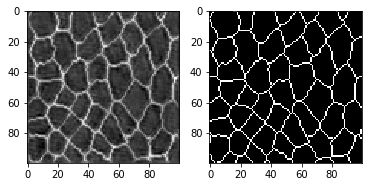

Estimate_g_m: 0.093327455
Estimate_r_m: 0.41165024
Estimate_g_v: 0.0037337379
Estimate_r_v: 0.075949274
Iteration: 1660 at 2018-02-22 19:47:44.716505


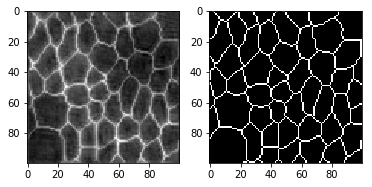

Estimate_g_m: -0.20159736
Estimate_r_m: -0.050610706
Estimate_g_v: 0.050989963
Estimate_r_v: 0.04879649
Iteration: 1670 at 2018-02-22 19:47:57.766523


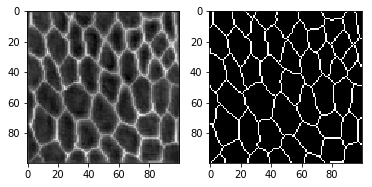

Estimate_g_m: 0.046148654
Estimate_r_m: 0.3301742
Estimate_g_v: 0.008608617
Estimate_r_v: 0.05188515
Iteration: 1680 at 2018-02-22 19:48:11.226542


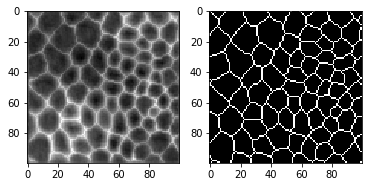

Estimate_g_m: -0.00981656
Estimate_r_m: 0.2023985
Estimate_g_v: 0.10443901
Estimate_r_v: 0.22702897
Iteration: 1690 at 2018-02-22 19:48:24.546560


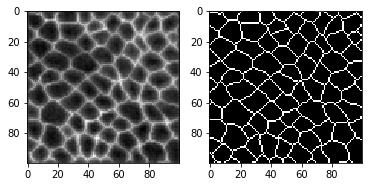

Estimate_g_m: -0.007919498
Estimate_r_m: 0.20779113
Estimate_g_v: 0.03290355
Estimate_r_v: 0.09339598
Iteration: 1700 at 2018-02-22 19:48:37.556579


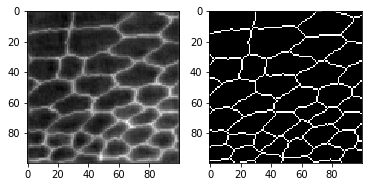

Estimate_g_m: -0.036733497
Estimate_r_m: 0.43542886
Estimate_g_v: 0.059426438
Estimate_r_v: 0.39456624
Iteration: 1710 at 2018-02-22 19:48:50.766597


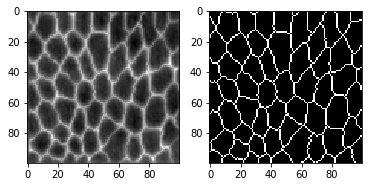

Estimate_g_m: -0.18806136
Estimate_r_m: -0.06999022
Estimate_g_v: 0.030966304
Estimate_r_v: 0.043633156
Iteration: 1720 at 2018-02-22 19:49:03.866616


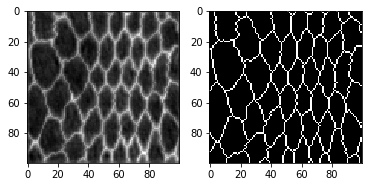

Estimate_g_m: -0.04032835
Estimate_r_m: 0.13770284
Estimate_g_v: 0.058847208
Estimate_r_v: 0.1304281
Iteration: 1730 at 2018-02-22 19:49:17.166634


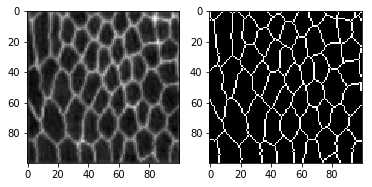

Estimate_g_m: -0.016819138
Estimate_r_m: 0.31559384
Estimate_g_v: 0.096995264
Estimate_r_v: 0.2772672
Iteration: 1740 at 2018-02-22 19:49:30.346653


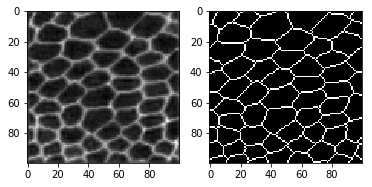

Estimate_g_m: 0.07941302
Estimate_r_m: 0.22305395
Estimate_g_v: 0.034401633
Estimate_r_v: 0.069562435
Iteration: 1750 at 2018-02-22 19:49:43.637671


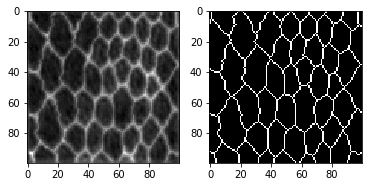

Estimate_g_m: 0.091969445
Estimate_r_m: 0.38370293
Estimate_g_v: 0.114774905
Estimate_r_v: 0.11648512
Iteration: 1760 at 2018-02-22 19:49:56.907690


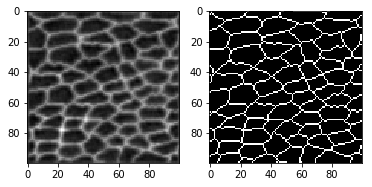

Estimate_g_m: -0.22964539
Estimate_r_m: 0.04669544
Estimate_g_v: 0.02242886
Estimate_r_v: 0.11999526
Iteration: 1770 at 2018-02-22 19:50:10.328709


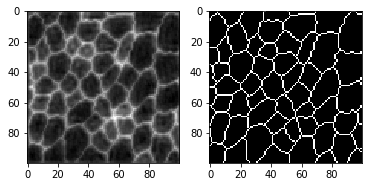

Estimate_g_m: -0.42665958
Estimate_r_m: -0.14238775
Estimate_g_v: 0.105300695
Estimate_r_v: 0.18645391
Iteration: 1780 at 2018-02-22 19:50:23.698727


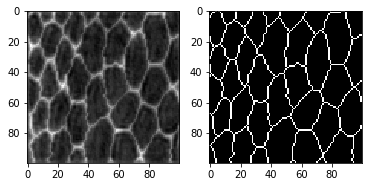

Estimate_g_m: -0.03793422
Estimate_r_m: 0.05436013
Estimate_g_v: 0.104982205
Estimate_r_v: 0.0888007
Iteration: 1790 at 2018-02-22 19:50:36.908746


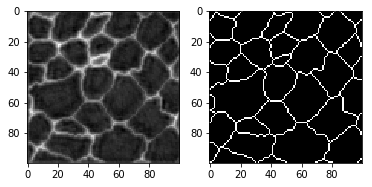

Estimate_g_m: -0.053266797
Estimate_r_m: 0.2370916
Estimate_g_v: 0.20415306
Estimate_r_v: 0.26766244
Iteration: 1800 at 2018-02-22 19:50:50.638765


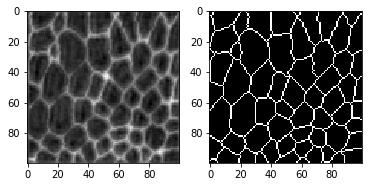

Estimate_g_m: 0.028634388
Estimate_r_m: 0.399074
Estimate_g_v: 0.14674704
Estimate_r_v: 0.37289497
Iteration: 1810 at 2018-02-22 19:51:03.868784


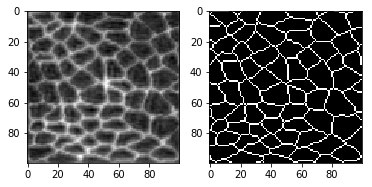

Estimate_g_m: 0.24879941
Estimate_r_m: 0.39914975
Estimate_g_v: 0.11932975
Estimate_r_v: 0.2884667
Iteration: 1820 at 2018-02-22 19:51:18.768805


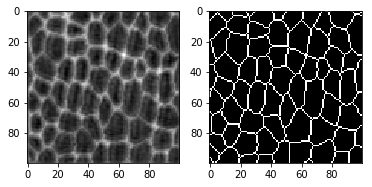

Estimate_g_m: 0.022251504
Estimate_r_m: 0.23550281
Estimate_g_v: 0.07559614
Estimate_r_v: 0.19037151
Iteration: 1830 at 2018-02-22 19:51:31.938823


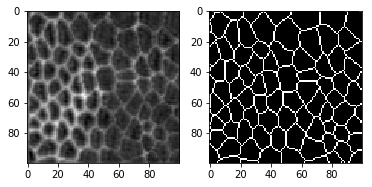

Estimate_g_m: -0.2101754
Estimate_r_m: -0.0025211638
Estimate_g_v: 0.04727362
Estimate_r_v: 0.14114834
Iteration: 1840 at 2018-02-22 19:51:45.448842


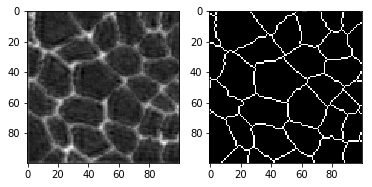

Estimate_g_m: -0.5504778
Estimate_r_m: -0.44356957
Estimate_g_v: 0.08365768
Estimate_r_v: 0.116824105
Iteration: 1850 at 2018-02-22 19:51:58.968861


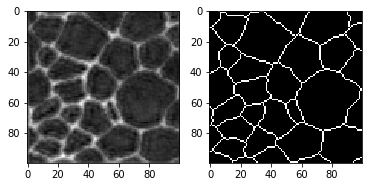

Estimate_g_m: -0.12610321
Estimate_r_m: 0.11375066
Estimate_g_v: 0.16149195
Estimate_r_v: 0.22515135
Iteration: 1860 at 2018-02-22 19:52:12.378880


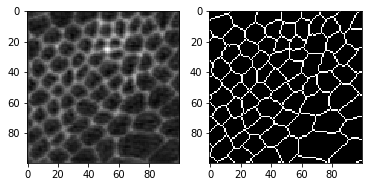

Estimate_g_m: 0.024159456
Estimate_r_m: 0.39133286
Estimate_g_v: 0.13997534
Estimate_r_v: 0.5979864
Iteration: 1870 at 2018-02-22 19:52:25.918899


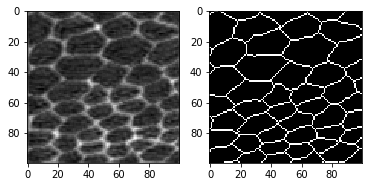

Estimate_g_m: 0.074756905
Estimate_r_m: 0.36720967
Estimate_g_v: 0.11238161
Estimate_r_v: 0.26613653
Iteration: 1880 at 2018-02-22 19:52:39.378917


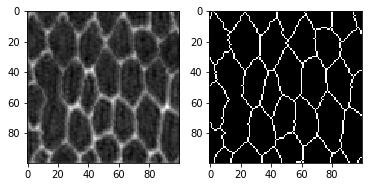

Estimate_g_m: -0.094913274
Estimate_r_m: 0.15181966
Estimate_g_v: 0.12150016
Estimate_r_v: 0.2630804
Iteration: 1890 at 2018-02-22 19:52:52.838936


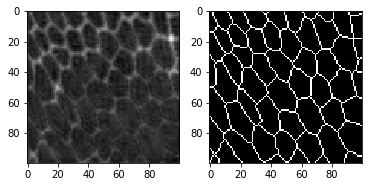

Estimate_g_m: -0.05396681
Estimate_r_m: 0.4840081
Estimate_g_v: 0.11866006
Estimate_r_v: 0.48880532
Iteration: 1900 at 2018-02-22 19:53:06.478955


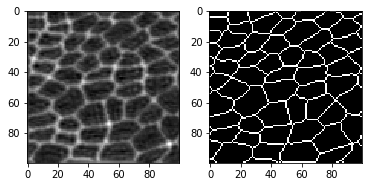

Estimate_g_m: 0.12335228
Estimate_r_m: 0.30217135
Estimate_g_v: 0.09723356
Estimate_r_v: 0.17267914
Iteration: 1910 at 2018-02-22 19:53:20.068974


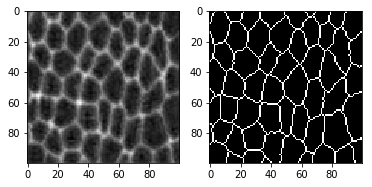

Estimate_g_m: -0.62368727
Estimate_r_m: -0.40434754
Estimate_g_v: 0.092963114
Estimate_r_v: 0.17450273
Iteration: 1920 at 2018-02-22 19:53:33.508993


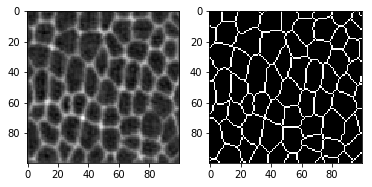

Estimate_g_m: -0.12191428
Estimate_r_m: 0.3350013
Estimate_g_v: 0.020908205
Estimate_r_v: 0.23567148
Iteration: 1930 at 2018-02-22 19:53:47.099012


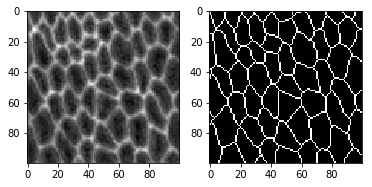

Estimate_g_m: 0.013200398
Estimate_r_m: 0.33505234
Estimate_g_v: 0.1607001
Estimate_r_v: 0.53427905
Iteration: 1940 at 2018-02-22 19:54:00.749031


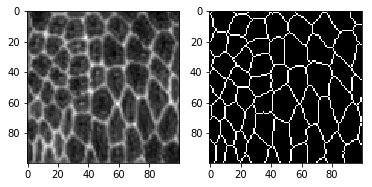

Estimate_g_m: -0.23001021
Estimate_r_m: -0.0039446363
Estimate_g_v: 0.35984996
Estimate_r_v: 0.49252117
Iteration: 1950 at 2018-02-22 19:54:14.409050


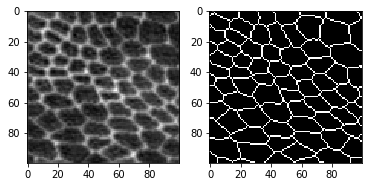

Estimate_g_m: -0.058937106
Estimate_r_m: 0.3418183
Estimate_g_v: 0.08626236
Estimate_r_v: 0.2698163
Iteration: 1960 at 2018-02-22 19:54:27.939069


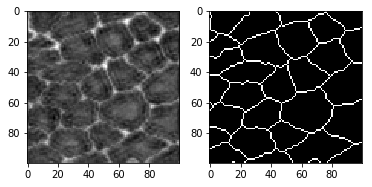

Estimate_g_m: -0.273378
Estimate_r_m: 0.29055917
Estimate_g_v: 0.09433791
Estimate_r_v: 0.43654737
Iteration: 1970 at 2018-02-22 19:54:41.709089


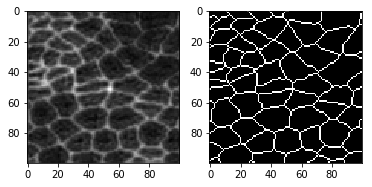

Estimate_g_m: -0.022007016
Estimate_r_m: 0.4165863
Estimate_g_v: 0.24827272
Estimate_r_v: 0.5511396
Iteration: 1980 at 2018-02-22 19:54:55.119107


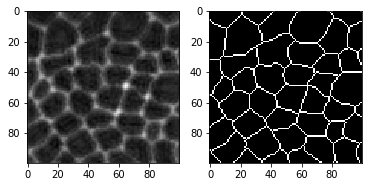

Estimate_g_m: -0.07509978
Estimate_r_m: 0.04819249
Estimate_g_v: 0.14036989
Estimate_r_v: 0.20641015
Iteration: 1990 at 2018-02-22 19:55:08.679126


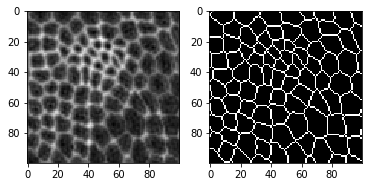

Estimate_g_m: -0.2785076
Estimate_r_m: 0.2368034
Estimate_g_v: 0.09860988
Estimate_r_v: 0.6201445
Iteration: 2000 at 2018-02-22 19:55:22.209145


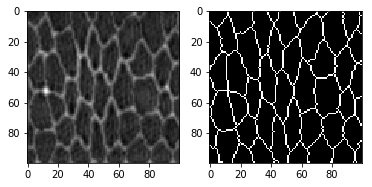

Estimate_g_m: -0.30695516
Estimate_r_m: 0.08975794
Estimate_g_v: 0.048894
Estimate_r_v: 0.38008654
Iteration: 2010 at 2018-02-22 19:55:35.649164


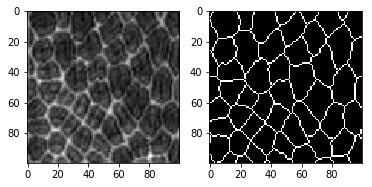

Estimate_g_m: 0.19126682
Estimate_r_m: 0.33575004
Estimate_g_v: 0.22301662
Estimate_r_v: 0.33678243
Iteration: 2020 at 2018-02-22 19:55:49.369183


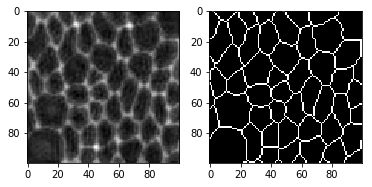

Estimate_g_m: -0.17026497
Estimate_r_m: 0.11167472
Estimate_g_v: 0.25741577
Estimate_r_v: 0.38347626
Iteration: 2030 at 2018-02-22 19:56:02.969202


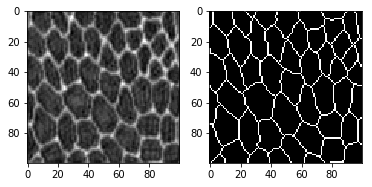

Estimate_g_m: 0.026922466
Estimate_r_m: 0.6945953
Estimate_g_v: 0.082033664
Estimate_r_v: 0.54118454
Iteration: 2040 at 2018-02-22 19:56:16.549221


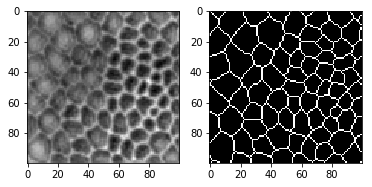

Estimate_g_m: -0.7043913
Estimate_r_m: 0.15541297
Estimate_g_v: 0.11552344
Estimate_r_v: 0.65248406
Iteration: 2050 at 2018-02-22 19:56:30.199241


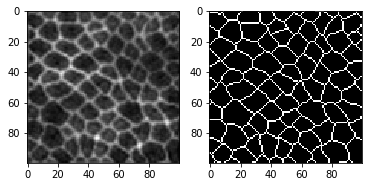

Estimate_g_m: -0.4842949
Estimate_r_m: 0.07453673
Estimate_g_v: 0.3898392
Estimate_r_v: 0.62331015
Iteration: 2060 at 2018-02-22 19:56:43.909260


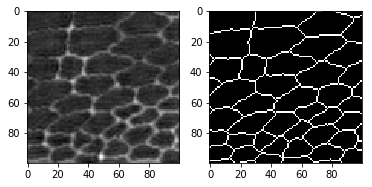

Estimate_g_m: 0.13030067
Estimate_r_m: 0.97764087
Estimate_g_v: 0.2701918
Estimate_r_v: 1.3133805
Iteration: 2070 at 2018-02-22 19:56:57.579279


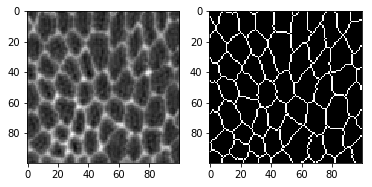

Estimate_g_m: -0.11070035
Estimate_r_m: 0.097314335
Estimate_g_v: 0.21364428
Estimate_r_v: 0.56407154
Iteration: 2080 at 2018-02-22 19:57:11.289298


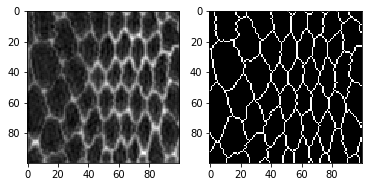

Estimate_g_m: -0.14354017
Estimate_r_m: -0.0017664713
Estimate_g_v: 0.18655683
Estimate_r_v: 0.14436918
Iteration: 2090 at 2018-02-22 19:57:25.129317


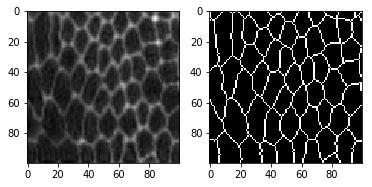

Estimate_g_m: -0.15405205
Estimate_r_m: 0.12613206
Estimate_g_v: 0.33606812
Estimate_r_v: 0.39891696
Iteration: 2100 at 2018-02-22 19:57:38.809337


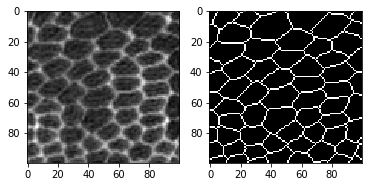

Estimate_g_m: 0.113920316
Estimate_r_m: 0.2626498
Estimate_g_v: 0.097373724
Estimate_r_v: 0.16858155
Iteration: 2110 at 2018-02-22 19:57:52.519356


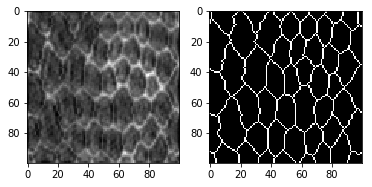

Estimate_g_m: -0.18981665
Estimate_r_m: 0.06296239
Estimate_g_v: 0.19541094
Estimate_r_v: 0.1935792
Iteration: 2120 at 2018-02-22 19:58:06.403376


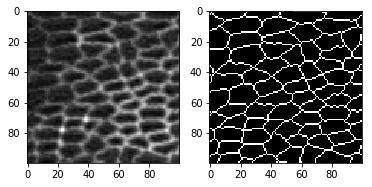

Estimate_g_m: 0.036255434
Estimate_r_m: 0.24932458
Estimate_g_v: 0.16323294
Estimate_r_v: 0.27788073
Iteration: 2130 at 2018-02-22 19:58:20.153395


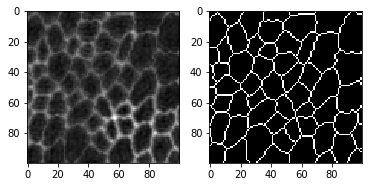

Estimate_g_m: -0.08006196
Estimate_r_m: 0.40888414
Estimate_g_v: 0.14518608
Estimate_r_v: 0.43246192
Iteration: 2140 at 2018-02-22 19:58:34.103425


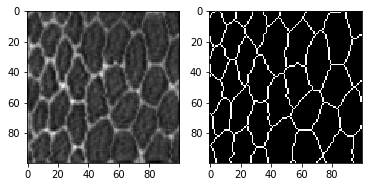

Estimate_g_m: -0.13703485
Estimate_r_m: 0.0049534114
Estimate_g_v: 0.119686276
Estimate_r_v: 0.16810384
Iteration: 2150 at 2018-02-22 19:58:47.923445


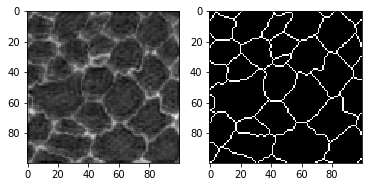

Estimate_g_m: 0.086569935
Estimate_r_m: 0.4924315
Estimate_g_v: 0.3126114
Estimate_r_v: 0.48433626
Iteration: 2160 at 2018-02-22 19:59:01.615464


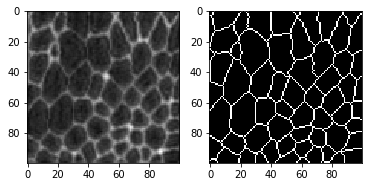

Estimate_g_m: 0.09025216
Estimate_r_m: 0.31862584
Estimate_g_v: 0.25246274
Estimate_r_v: 0.46995324
Iteration: 2170 at 2018-02-22 19:59:17.725487


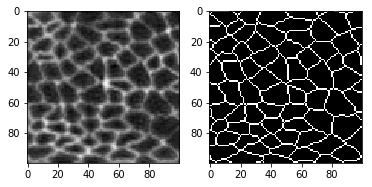

Estimate_g_m: -0.31252253
Estimate_r_m: -0.054203596
Estimate_g_v: 0.18222354
Estimate_r_v: 0.2208086
Iteration: 2180 at 2018-02-22 19:59:31.565506


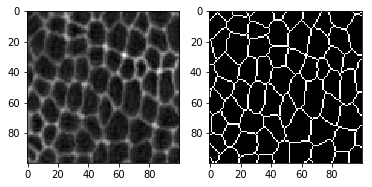

Estimate_g_m: -0.015193427
Estimate_r_m: 0.24480705
Estimate_g_v: 0.13425502
Estimate_r_v: 0.24060188
Iteration: 2190 at 2018-02-22 19:59:45.225525


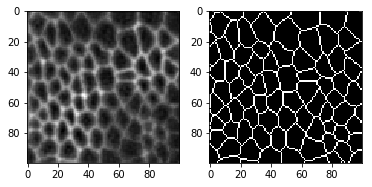

Estimate_g_m: -0.023581043
Estimate_r_m: 0.14172128
Estimate_g_v: 0.4143234
Estimate_r_v: 0.2066867
Iteration: 2200 at 2018-02-22 19:59:59.096545


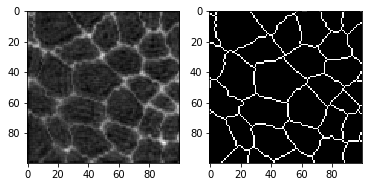

Estimate_g_m: -0.068368234
Estimate_r_m: 0.20585836
Estimate_g_v: 0.22404507
Estimate_r_v: 0.43387118
Iteration: 2210 at 2018-02-22 20:00:12.966564


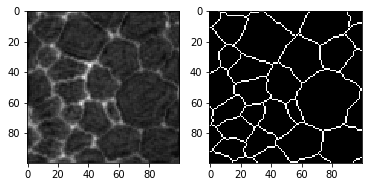

Estimate_g_m: -0.08579305
Estimate_r_m: 0.20241599
Estimate_g_v: 0.1551532
Estimate_r_v: 0.25942805
Iteration: 2220 at 2018-02-22 20:00:26.796583


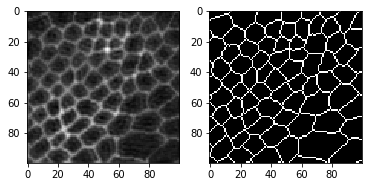

Estimate_g_m: -0.19884002
Estimate_r_m: 0.22843781
Estimate_g_v: 0.17590865
Estimate_r_v: 0.37515122
Iteration: 2230 at 2018-02-22 20:00:40.866603


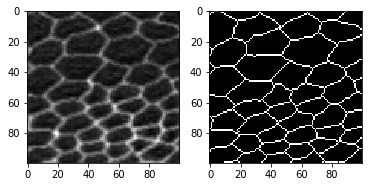

Estimate_g_m: 0.032963924
Estimate_r_m: 0.31329328
Estimate_g_v: 0.14850932
Estimate_r_v: 0.4640699
Iteration: 2240 at 2018-02-22 20:00:54.747622


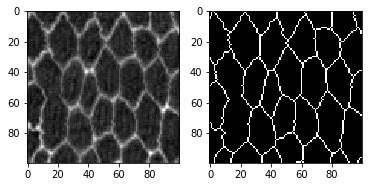

Estimate_g_m: -0.07347686
Estimate_r_m: 0.3691262
Estimate_g_v: 0.12561052
Estimate_r_v: 0.23412506
Iteration: 2250 at 2018-02-22 20:01:08.728642


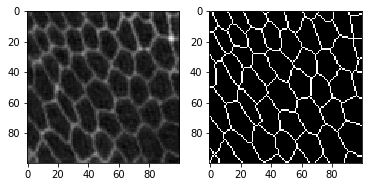

Estimate_g_m: -0.1653412
Estimate_r_m: 0.26147228
Estimate_g_v: 0.28930497
Estimate_r_v: 0.4917692
Iteration: 2260 at 2018-02-22 20:01:22.878662


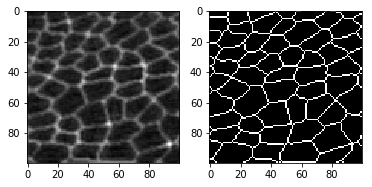

Estimate_g_m: -0.08431534
Estimate_r_m: 0.22162266
Estimate_g_v: 0.17719345
Estimate_r_v: 0.374136
Iteration: 2270 at 2018-02-22 20:01:36.799681


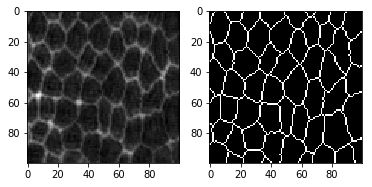

Estimate_g_m: -0.17700109
Estimate_r_m: 0.29115516
Estimate_g_v: 0.21385117
Estimate_r_v: 0.24324699
Iteration: 2280 at 2018-02-22 20:01:51.109702


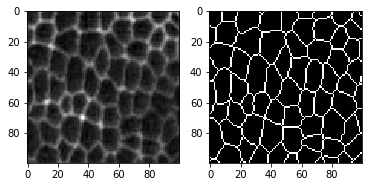

Estimate_g_m: -0.08894795
Estimate_r_m: 0.09407034
Estimate_g_v: 0.15930377
Estimate_r_v: 0.3002482
Iteration: 2290 at 2018-02-22 20:02:05.030721


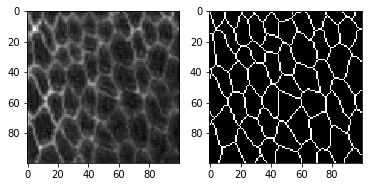

Estimate_g_m: -0.073335625
Estimate_r_m: 0.41902438
Estimate_g_v: 0.3128173
Estimate_r_v: 0.44341555
Iteration: 2300 at 2018-02-22 20:02:19.020741


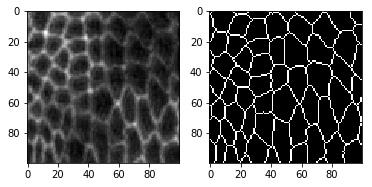

Estimate_g_m: -0.67127067
Estimate_r_m: -0.5109775
Estimate_g_v: 0.34882382
Estimate_r_v: 0.31215405
Iteration: 2310 at 2018-02-22 20:02:32.901760


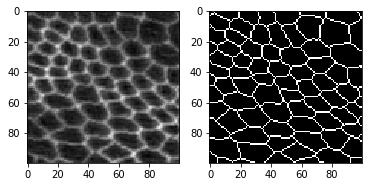

Estimate_g_m: -0.10394138
Estimate_r_m: 0.48902413
Estimate_g_v: 0.15766786
Estimate_r_v: 0.4784382
Iteration: 2320 at 2018-02-22 20:02:46.881780


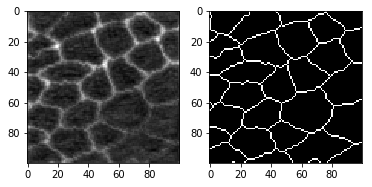

Estimate_g_m: -0.07399467
Estimate_r_m: 0.36192828
Estimate_g_v: 0.35583577
Estimate_r_v: 0.46848625
Iteration: 2330 at 2018-02-22 20:03:00.811799


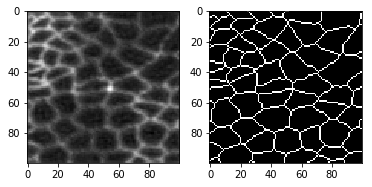

Estimate_g_m: 0.18944235
Estimate_r_m: 0.49603367
Estimate_g_v: 0.45225716
Estimate_r_v: 0.81413114
Iteration: 2340 at 2018-02-22 20:03:14.891819


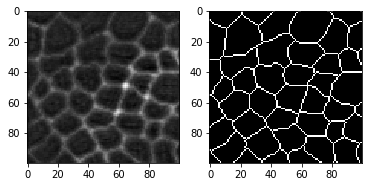

Estimate_g_m: 0.08702573
Estimate_r_m: 0.32236072
Estimate_g_v: 0.14872314
Estimate_r_v: 0.20499554
Iteration: 2350 at 2018-02-22 20:03:28.951839


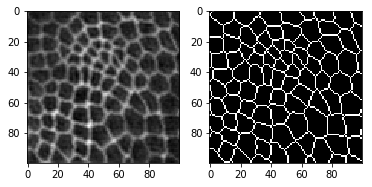

Estimate_g_m: -0.34063947
Estimate_r_m: 0.21237428
Estimate_g_v: 0.20497704
Estimate_r_v: 0.5431741
Iteration: 2360 at 2018-02-22 20:03:43.271859


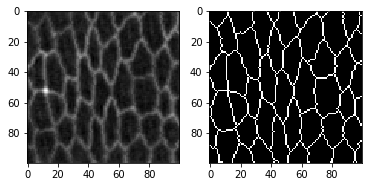

Estimate_g_m: -0.013066407
Estimate_r_m: 0.51779294
Estimate_g_v: 0.22628948
Estimate_r_v: 0.76238805
Iteration: 2370 at 2018-02-22 20:03:57.482879


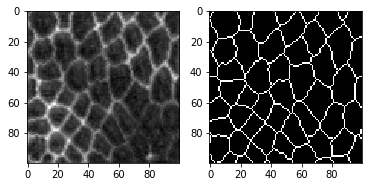

Estimate_g_m: 0.14294721
Estimate_r_m: 1.0940111
Estimate_g_v: 0.62890655
Estimate_r_v: 1.5709409
Iteration: 2380 at 2018-02-22 20:04:11.602898


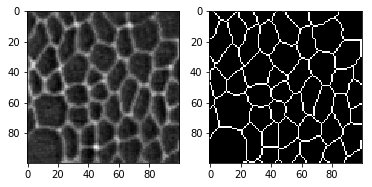

Estimate_g_m: -0.34511766
Estimate_r_m: 0.22378165
Estimate_g_v: 0.12004273
Estimate_r_v: 0.5094367
Iteration: 2390 at 2018-02-22 20:04:25.882918


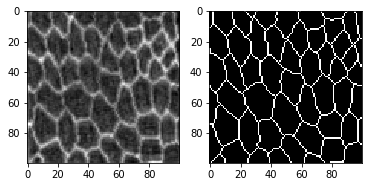

Estimate_g_m: -0.01473111
Estimate_r_m: 0.8220891
Estimate_g_v: 0.13382006
Estimate_r_v: 1.3319983
Iteration: 2400 at 2018-02-22 20:04:40.003938


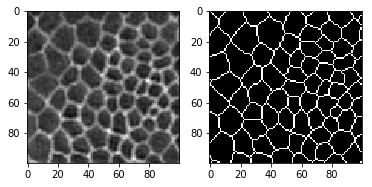

Estimate_g_m: -0.09376851
Estimate_r_m: 0.80452913
Estimate_g_v: 0.18521562
Estimate_r_v: 1.8697143
Iteration: 2410 at 2018-02-22 20:04:54.083958


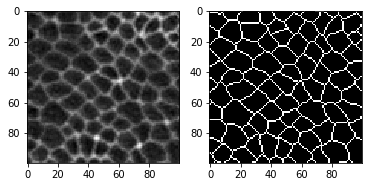

Estimate_g_m: -0.23666005
Estimate_r_m: 0.59112346
Estimate_g_v: 0.32848793
Estimate_r_v: 1.3883948
Iteration: 2420 at 2018-02-22 20:05:08.104978


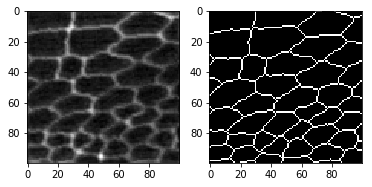

Estimate_g_m: -0.1341919
Estimate_r_m: 0.35130566
Estimate_g_v: 0.27965346
Estimate_r_v: 0.5920882
Iteration: 2430 at 2018-02-22 20:05:22.554998


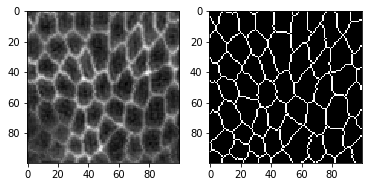

Estimate_g_m: 0.18590859
Estimate_r_m: 0.3792404
Estimate_g_v: 0.61820674
Estimate_r_v: 0.6915209
Iteration: 2440 at 2018-02-22 20:05:36.725018


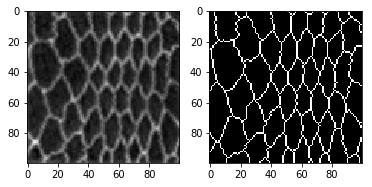

Estimate_g_m: -0.019408287
Estimate_r_m: 0.4044342
Estimate_g_v: 0.15888497
Estimate_r_v: 0.4051025
Iteration: 2450 at 2018-02-22 20:05:51.155038


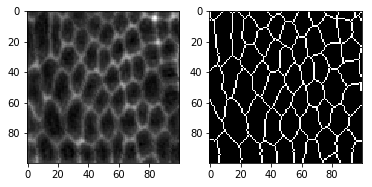

Estimate_g_m: -0.0033531643
Estimate_r_m: 0.24378777
Estimate_g_v: 0.23697907
Estimate_r_v: 0.47266683
Iteration: 2460 at 2018-02-22 20:06:05.275058


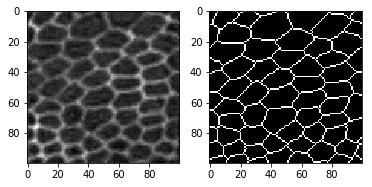

Estimate_g_m: 0.08976951
Estimate_r_m: 0.3366335
Estimate_g_v: 0.20321347
Estimate_r_v: 0.4797155
Iteration: 2470 at 2018-02-22 20:06:19.615078


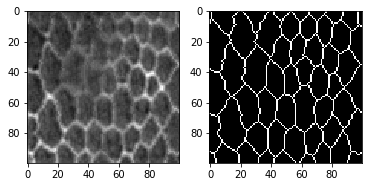

Estimate_g_m: -0.05778549
Estimate_r_m: 0.3036066
Estimate_g_v: 0.17137302
Estimate_r_v: 0.53337616
Iteration: 2480 at 2018-02-22 20:06:33.875098


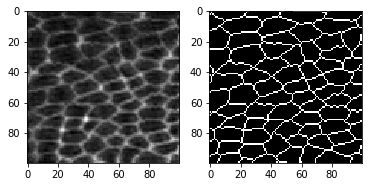

Estimate_g_m: 0.01976194
Estimate_r_m: 0.3281389
Estimate_g_v: 0.12450481
Estimate_r_v: 0.33073345
Iteration: 2490 at 2018-02-22 20:06:48.005117


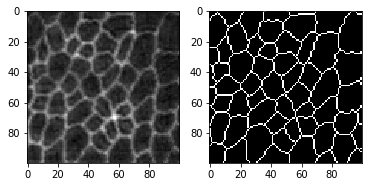

Estimate_g_m: -0.30139607
Estimate_r_m: 0.41030064
Estimate_g_v: 0.18595725
Estimate_r_v: 0.856179
Iteration: 2500 at 2018-02-22 20:07:02.075137


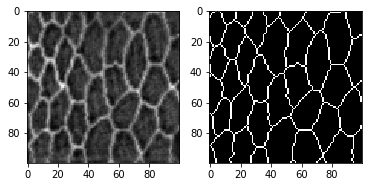

Estimate_g_m: -0.17870241
Estimate_r_m: 0.09990688
Estimate_g_v: 0.11962659
Estimate_r_v: 0.16856518
Iteration: 2510 at 2018-02-22 20:07:16.495157


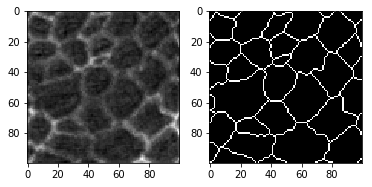

Estimate_g_m: -0.014137196
Estimate_r_m: 0.4928912
Estimate_g_v: 0.34409347
Estimate_r_v: 0.8998899
Iteration: 2520 at 2018-02-22 20:07:30.825177


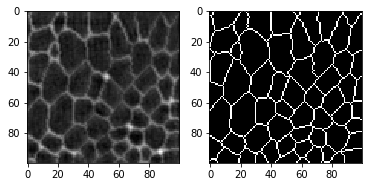

Estimate_g_m: -0.05910787
Estimate_r_m: 0.4996218
Estimate_g_v: 0.15986484
Estimate_r_v: 1.0766718
Iteration: 2530 at 2018-02-22 20:07:45.555198


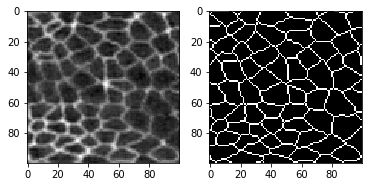

Estimate_g_m: 0.04632063
Estimate_r_m: 0.32333198
Estimate_g_v: 0.13147286
Estimate_r_v: 0.21923439
Iteration: 2540 at 2018-02-22 20:07:59.695218


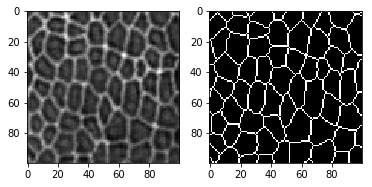

Estimate_g_m: -0.16509336
Estimate_r_m: 0.20357881
Estimate_g_v: 0.112745255
Estimate_r_v: 0.46889687
Iteration: 2550 at 2018-02-22 20:08:14.245238


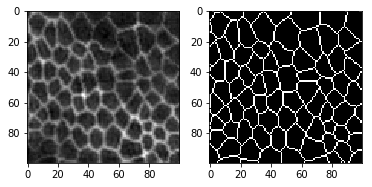

Estimate_g_m: 0.110806465
Estimate_r_m: 0.4097842
Estimate_g_v: 0.48130813
Estimate_r_v: 0.41444865
Iteration: 2560 at 2018-02-22 20:08:28.485258


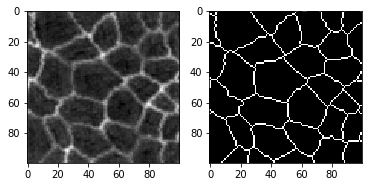

Estimate_g_m: -0.15298389
Estimate_r_m: 0.30766475
Estimate_g_v: 0.1975402
Estimate_r_v: 0.43475875
Iteration: 2570 at 2018-02-22 20:08:45.695282


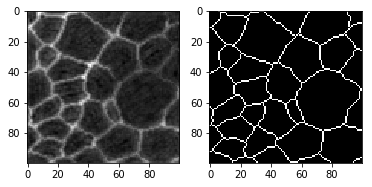

Estimate_g_m: 0.07335837
Estimate_r_m: 0.614089
Estimate_g_v: 0.29949534
Estimate_r_v: 0.9560507
Iteration: 2580 at 2018-02-22 20:09:01.125304


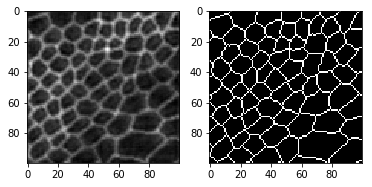

Estimate_g_m: 0.121178195
Estimate_r_m: 0.67117333
Estimate_g_v: 0.4564163
Estimate_r_v: 0.48140025
Iteration: 2590 at 2018-02-22 20:09:16.475325


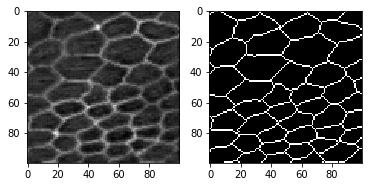

Estimate_g_m: 0.1246589
Estimate_r_m: 0.68053526
Estimate_g_v: 0.18126944
Estimate_r_v: 1.028624
Iteration: 2600 at 2018-02-22 20:09:31.615346


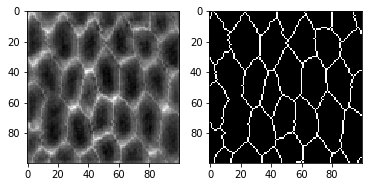

Estimate_g_m: -0.24797441
Estimate_r_m: 0.20637685
Estimate_g_v: 0.26911294
Estimate_r_v: 0.50220317
Iteration: 2610 at 2018-02-22 20:09:46.675368


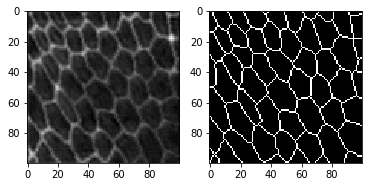

Estimate_g_m: -0.18975015
Estimate_r_m: 0.43422276
Estimate_g_v: 0.27162507
Estimate_r_v: 0.43965194
Iteration: 2620 at 2018-02-22 20:10:01.245388


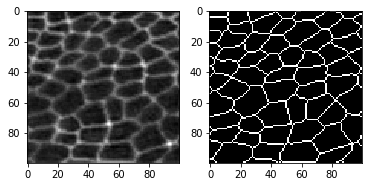

Estimate_g_m: -0.05528351
Estimate_r_m: 0.38224778
Estimate_g_v: 0.21257086
Estimate_r_v: 0.4905161
Iteration: 2630 at 2018-02-22 20:10:15.955409


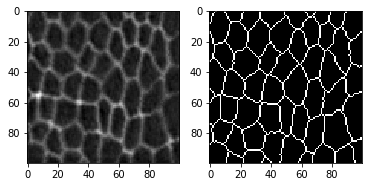

Estimate_g_m: 0.07618586
Estimate_r_m: 0.7628008
Estimate_g_v: 0.23236518
Estimate_r_v: 0.6671244
Iteration: 2640 at 2018-02-22 20:10:30.505429


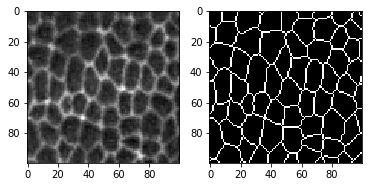

Estimate_g_m: -0.105426386
Estimate_r_m: 0.4001958
Estimate_g_v: 0.21695948
Estimate_r_v: 0.4061478
Iteration: 2650 at 2018-02-22 20:10:45.105449


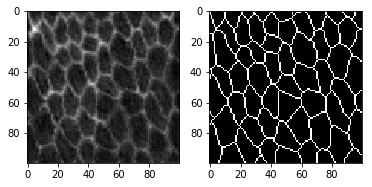

Estimate_g_m: -0.08666301
Estimate_r_m: 0.7148358
Estimate_g_v: 0.44174957
Estimate_r_v: 0.8971703
Iteration: 2660 at 2018-02-22 20:10:59.705470


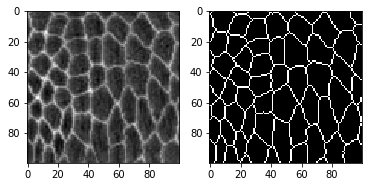

Estimate_g_m: -1.1111568
Estimate_r_m: -0.6736107
Estimate_g_v: 0.09620466
Estimate_r_v: 0.2441018
Iteration: 2670 at 2018-02-22 20:11:14.175490


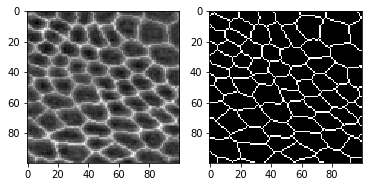

Estimate_g_m: -0.09085284
Estimate_r_m: 0.28542638
Estimate_g_v: 0.09759425
Estimate_r_v: 0.3988405
Iteration: 2680 at 2018-02-22 20:11:28.595510


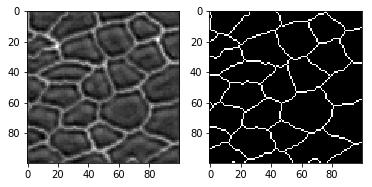

Estimate_g_m: -0.12532803
Estimate_r_m: 0.32374018
Estimate_g_v: 0.07543654
Estimate_r_v: 0.24967986
Iteration: 2690 at 2018-02-22 20:11:43.095531


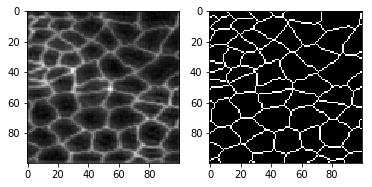

Estimate_g_m: -0.023720548
Estimate_r_m: 0.7348378
Estimate_g_v: 0.38651848
Estimate_r_v: 0.42543694
Iteration: 2700 at 2018-02-22 20:11:57.755551


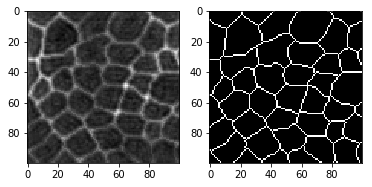

Estimate_g_m: -0.03141797
Estimate_r_m: 0.6067863
Estimate_g_v: 0.345242
Estimate_r_v: 0.24169965
Iteration: 2710 at 2018-02-22 20:12:12.135571


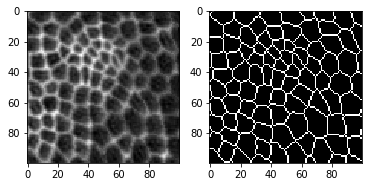

Estimate_g_m: -0.055957295
Estimate_r_m: 0.84813285
Estimate_g_v: 0.7300927
Estimate_r_v: 1.1795856


KeyboardInterrupt: 

In [166]:
# training begins here

sess.run(tf.global_variables_initializer())

# Pre-train discriminator
for i in range(100):
#     z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
#     z_batch = np.random.normal(0, 1, size=[batch_size, 100,100,1])
    real_image_batch = x.next_batch(batch_size).reshape([batch_size,100,100,1])
    gt_image_batch = y.next_batch(batch_size).reshape([batch_size,100,100,1])
#     _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
#                                            {x_placeholder: real_image_batch, z_placeholder: z_batch})

    _, dLossAll = sess.run([d_trainer_all, d_loss_all],
                                           {x_placeholder: real_image_batch, z_placeholder: gt_image_batch})

#     if(i % 100 == 0):
#         print("dLossReal:", dLossReal, "dLossFake:", dLossFake)

    if(i % 100 == 0):
        print("dLossAll:", dLossAll)

# Train generator and discriminator together
for i in range(100000):
    real_image_batch = x.next_batch(batch_size).reshape([batch_size,100,100,1])
    gt_image_batch = y.next_batch(batch_size).reshape([batch_size,100,100,1])
#     z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
#     z_batch = np.random.normal(0, 1, size=[batch_size, 100,100,1])

    # Train discriminator on both real and fake images
#     _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
#                                            {x_placeholder: real_image_batch, z_placeholder: z_batch})
    
    _, dLossAll = sess.run([d_trainer_all, d_loss_all],
                                           {x_placeholder: real_image_batch, z_placeholder: gt_image_batch})

    # Train generator
#     z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    gt_image_batch = y.next_batch(batch_size).reshape([batch_size,100,100,1])
#     z_batch = np.random.normal(0, 1, size=[batch_size, 100,100,1])
    _ = sess.run(g_trainer, feed_dict={z_placeholder: gt_image_batch})

    if i % 10 == 0:
        # Update TensorBoard 2with summary statistics
#         z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
        gt_image_batch = y.next_batch(batch_size).reshape([batch_size,100,100,1])
#         z_batch = np.random.normal(0, 1, size=[batch_size, 100,100,1])
        summary = sess.run(merged, {z_placeholder: gt_image_batch, x_placeholder: real_image_batch})
        writer.add_summary(summary, i)

#     if i % 10 == 0:
        # Every 100 iterations, show a generated image
        print("Iteration:", i, "at", datetime.datetime.now())
#         z_batch = np.random.normal(0, 1, size=[1, z_dimensions])
#         z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
        gt_image_batch = y.next_batch(batch_size).reshape([batch_size,100,100,1])
#         z_batch = np.random.normal(0, 1, size=[batch_size, 100,100,1])
        generated_images = generator(z_placeholder, batch_size, z_dimensions)
        images = sess.run(generated_images, {z_placeholder: gt_image_batch})
        plt.subplot(121)
        plt.imshow(images[0].reshape([100, 100]), cmap='gray')
        plt.subplot(122)
        plt.imshow(gt_image_batch[0].reshape([100,100]), cmap='gray')
        plt.show()
#         s = tf.summary.image("interm", images[0].reshape([1,100, 100,1]))
#         summ = sess.run(s)
#         writer.add_summary(summ)

        # Show discriminator's estimate
#         im = images[0].reshape([1, 100, 100, 1])
#         result = discriminator(x_placeholder)
#         estimate = sess.run(result, {x_placeholder: im})

        im = images.reshape([-1, 100, 100, 1])
        result = discriminator(x_placeholder)
        estimate_all_batch = sess.run(result, {x_placeholder: np.concatenate((im,real_image_batch),axis=0)})
        estimate_r_batch = sess.run(result, {x_placeholder: real_image_batch})
#         estimate_all = sess.run(result, {x_placeholder: tf.concat(())})
        print("Estimate_g_m:", (np.mean(estimate_all_batch[0:batch_size])))
        print("Estimate_r_m:", (np.mean(estimate_all_batch[batch_size:])))
        print("Estimate_g_v:", (np.var(estimate_all_batch[0:batch_size])))
        print("Estimate_r_v:", (np.var(estimate_all_batch[batch_size:])))

In [ ]:
# dirToSave="./resources/models/"
# modelName = "refiner_1"
# # saving model
# json_string = model.to_json()

# import json
# with open('model_'+modelName+'_json', 'w') as outfile:
#     json.dump(json_string, outfile)
    
# # saving weights
# model.save_weights('model_'+modelName+'.h5')

In [ ]:
saver = tf.train.Saver()

In [167]:
from __future__ import print_function, unicode_literals, absolute_import, division

import tensorflow as tf
import os
import warnings
import tempfile, shutil
from keras import backend as K
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io

def export_SavedModel(outpath, format='zip'):
    # assert not os.path.exists(dirname)

    def export_to_dir(dirname):
#         if len(model.input_layers) > 1 or len(model.output_layers) > 1:
#             warnings.warn('not tested with multiple input or output layers')
        builder = tf.saved_model.builder.SavedModelBuilder(dirname)
        signature = tf.saved_model.signature_def_utils.predict_signature_def(
            inputs  = {"input":  z_placeholder},
            outputs = {"output": Gz}
        )
        signature_def_map = { tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY : signature }
        builder.add_meta_graph_and_variables(sess,
                                             [tf.saved_model.tag_constants.SERVING],
                                             signature_def_map=signature_def_map)
        builder.save()

    if format=='dir':
        export_to_dir(outpath)
    else:
        with tempfile.TemporaryDirectory() as tmpdir:
            tmpsubdir = os.path.join(tmpdir,'model')
            export_to_dir(tmpsubdir)
            shutil.make_archive(outpath, format, tmpsubdir)

Using TensorFlow backend.


In [168]:
export_SavedModel(outpath=".resources/models/model_refiner4", format="dir")

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'.resources/models/model_refiner4\\saved_model.pb'


In [171]:
sess1= tf.Session(graph=tf.Graph())
tf.saved_model.loader.load(sess1,[tf.saved_model.tag_constants.SERVING],".resources/models/model_refiner4")

INFO:tensorflow:Restoring parameters from b'.resources/models/model_refiner4\\variables\\variables'


In [ ]:
gtImg = gtListArray[0][np.newaxis,...,np.newaxis]
# sess1.run( {z_placeholder: gtImg})

In [173]:
gtImg.shape

(1, 100, 100, 1)

In [174]:
gtListArrayAugm.shape
mult = 10

In [175]:
output_tensor = sess1.graph.get_tensor_by_name('Elu_5:0')

In [176]:
gtImg = gtListArray[mult*50:mult*50+50][...,np.newaxis]

In [177]:
pr = sess1.run(output_tensor, {"z_placeholder:0":gtImg})

In [178]:
pr.shape

(50, 100, 100, 1)

(<matplotlib.image.AxesImage at 0x1f4801a58>,
 <matplotlib.colorbar.Colorbar at 0x1f4504f28>)

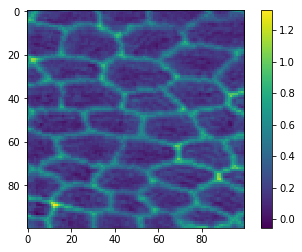

In [181]:
plt.imshow(pr[21,:,:,0]), plt.colorbar()

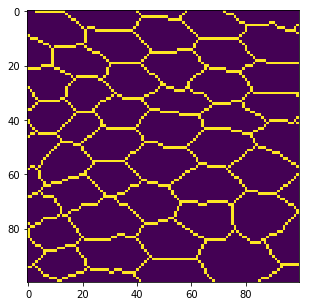

In [218]:
plt.imshow(gtImg[25,:,:,0])

In [219]:
import tifffile
genPatch = tifffile.imread("genPatch1.tif")

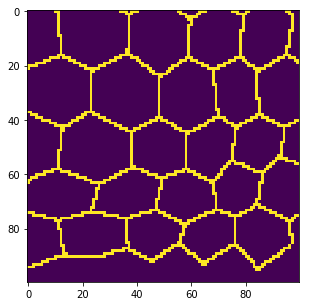

In [220]:
plt.rcParams['figure.figsize'] = 5,5
plt.imshow(genPatch)

In [221]:
genPatch.shape

(100, 100)

In [222]:
fakeBatch = np.zeros((50,100,100,1))

In [223]:
fakeBatch[0,:,:,0] = genPatch

In [224]:
pr = sess1.run(output_tensor, {"z_placeholder:0":fakeBatch})

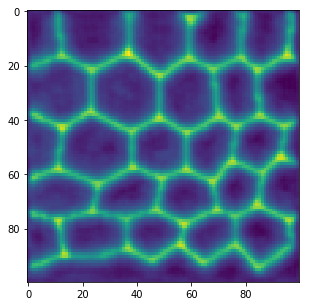

In [225]:
plt.imshow(pr[0,:,:,0])

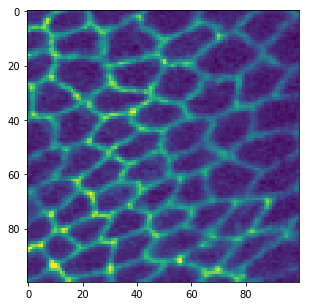

In [226]:
raw = rawListArray[500:550]
plt.imshow(raw[25,:,:])

In [227]:
g = gtListArray[500:550]

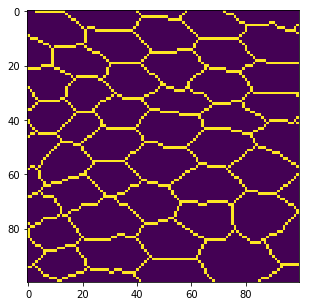

In [228]:
plt.imshow(g[25])

In [229]:
rawListArray.shape

(900, 100, 100)

In [ ]:
gtListArray.shape

In [ ]:
plt.imshow(rawListArray[0])

In [ ]:
plt.imshow(gtListArray[0])